# MIE 451/1513 Lab 3: Machine Learning
In this lab, we will explore the critical role of Machine Learning in Decision Support Systems by predicting future sales amounts based on historical data. We will delve into interpreting regression models to understand how different features contribute to sales changes. Additionally, we will employ Gradient Boosting techniques to handle complex, real-world data more effectively.

In [1]:
!pip install wget
!pip install scikit-learn==1.5

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import wget
import time as time

from sklearn.metrics import mean_absolute_error,mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb



In [3]:
filename = wget.download('https://github.com/MIE451-2024/course-datasets/raw/refs/heads/main/rossmann_store_sales_lab.zip', 'rossmann_store_sales_lab.zip')

In [4]:
!unzip rossmann_store_sales_lab.zip
DATA_DIR = 'rossmann_store_sales_lab'

Archive:  rossmann_store_sales_lab.zip
   creating: rossmann_store_sales_lab/
  inflating: rossmann_store_sales_lab/weather_data.csv  
  inflating: __MACOSX/rossmann_store_sales_lab/._weather_data.csv  
  inflating: rossmann_store_sales_lab/store_lab.csv  
  inflating: rossmann_store_sales_lab/test_lab.csv  
  inflating: rossmann_store_sales_lab/train_lab.csv  
  inflating: __MACOSX/rossmann_store_sales_lab/._train_lab.csv  
  inflating: rossmann_store_sales_lab/store_states.csv  
  inflating: __MACOSX/rossmann_store_sales_lab/._store_states.csv  


In [5]:
# importing the dataset
# this file contains the training data
sale_data = pd.read_csv(DATA_DIR + '/train_lab.csv')
# this file contains the store data for additional features
store_data = pd.read_csv(DATA_DIR + '/store_lab.csv')

## Exploratory Data Analysis

In [6]:
sale_data.head()

,Store,Date,DayOfWeek,Customers,Promo,StateHoliday,Sales
0,1,2015-06-01,1,607,1,0,5774
1,2,2015-06-01,1,673,1,0,6629
2,3,2015-06-01,1,1012,1,0,11594
3,4,2015-06-01,1,1695,1,0,13727
4,5,2015-06-01,1,778,1,0,8396


Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day


Promo - indicates whether a store is running a promo on that day

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


In [7]:
store_data.head()

,Store,StoreType,CompetitionDistance
0,1,c,1270.0
1,2,a,570.0
2,3,a,14130.0
3,4,c,620.0
4,5,a,29910.0


StoreType - differentiates between 4 different store models: a, b, c, d (The original dataset does not provide descriptions on the meaning of 'a,b,c,d' type)

CompetitionDistance - distance in meters to the nearest competitor store

In [8]:
# how many unique stores are there in each dataset?
len(store_data['Store'].unique()), len(sale_data['Store'].unique())

(1115, 200)

In [9]:
# What is the date range for dataset?
sale_data['Date'].min(), sale_data['Date'].max(), len(sale_data['Date'].unique())

('2013-01-01', '2015-06-01', 882)

In [10]:
sale_data['StateHoliday'] = sale_data['StateHoliday'].astype('str')
sale_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

 a = public holiday, b = Easter holiday, c = Christmas, 0 = None

In [11]:
sale_data.describe(include='all')

,Store,Date,DayOfWeek,Customers,Promo,StateHoliday,Sales
count,139308.00000,139308,139308.000000,139308.000000,139308.000000,139308,139308.000000
unique,NaN,882,NaN,NaN,NaN,4,NaN
top,NaN,2015-06-01,NaN,NaN,NaN,0,NaN
freq,NaN,200,NaN,NaN,NaN,139224,NaN
mean,105.25860,NaN,3.512218,707.419315,0.446873,NaN,6723.433737
std,85.26791,NaN,1.718819,268.371826,0.497171,NaN,2558.934575
min,1.00000,NaN,1.000000,0.000000,0.000000,NaN,0.000000
25%,50.00000,NaN,2.000000,523.000000,0.000000,NaN,4917.000000
50%,99.00000,NaN,3.000000,660.000000,0.000000,NaN,6333.000000
75%,150.00000,NaN,5.000000,842.000000,1.000000,NaN,8078.000000


In [12]:
store_data.describe(include='all')

,Store,StoreType,CompetitionDistance
count,1115.00000,1115,1112.000000
unique,NaN,4,NaN
top,NaN,a,NaN
freq,NaN,602,NaN
mean,558.00000,NaN,5404.901079
std,322.01708,NaN,7663.174720
min,1.00000,NaN,20.000000
25%,279.50000,NaN,717.500000
50%,558.00000,NaN,2325.000000
75%,836.50000,NaN,6882.500000


Text(7723.433736755966, 13000, 'Mean: 6723.43')

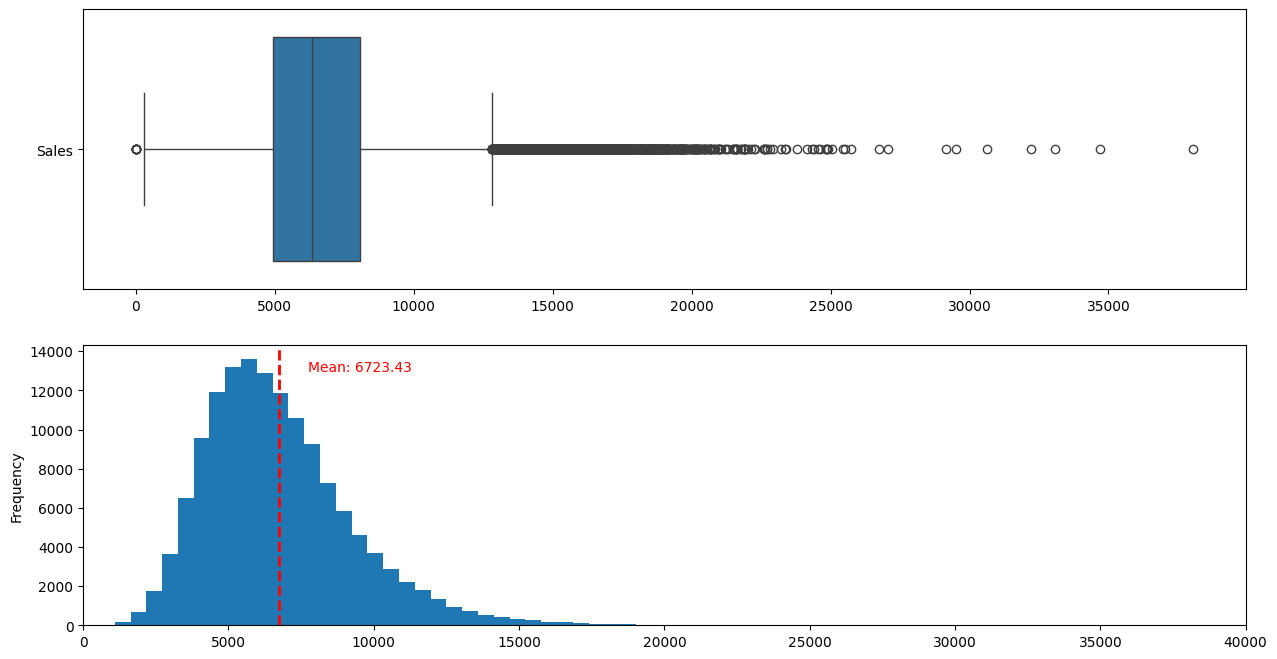

In [13]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([sale_data["Sales"]], ax=axis1, orient='h')

# Plot sales values
# Notice that values with 0 is mostly because the store was closed
sale_data["Sales"].plot(kind='hist',bins=70,xlim=(0,40000),ax=axis2)
sale_mean = sale_data["Sales"].mean()
axis2.axvline(sale_mean, color='r', linestyle='dashed', linewidth=2)
axis2.text(sale_mean+1000, 13000, 'Mean: {:.2f}'.format(sale_mean), color='red')

Text(707.4193154736267, 10000, 'Mean: 707.42')

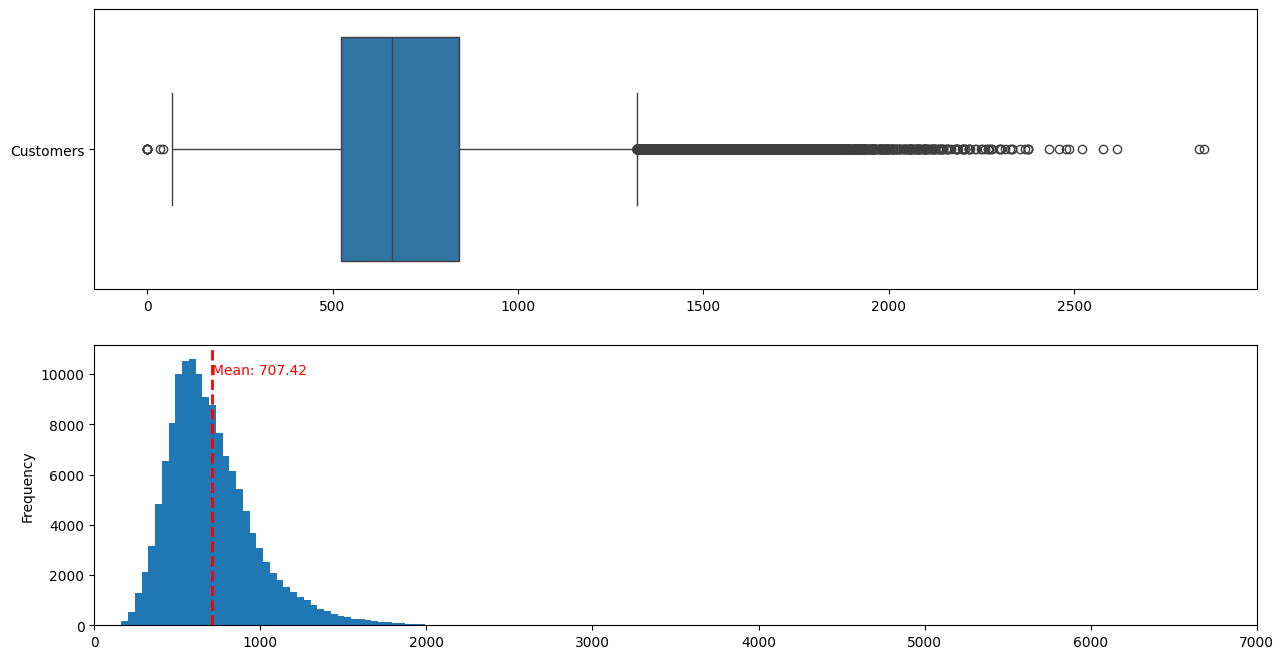

In [14]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([sale_data["Customers"]], ax=axis1, orient='h')

# Plot sales values
# Notice that values with 0 is mostly because the store was closed
sale_data["Customers"].plot(kind='hist',bins=70,xlim=(0,7000),ax=axis2)
c_mean = sale_data["Customers"].mean()
axis2.axvline(c_mean, color='r', linestyle='dashed', linewidth=2)
axis2.text(c_mean, 10000, 'Mean: {:.2f}'.format(c_mean), color='red')

Text(0.5, 1.0, 'Rolling Mean (7) of Sales During Study Period')

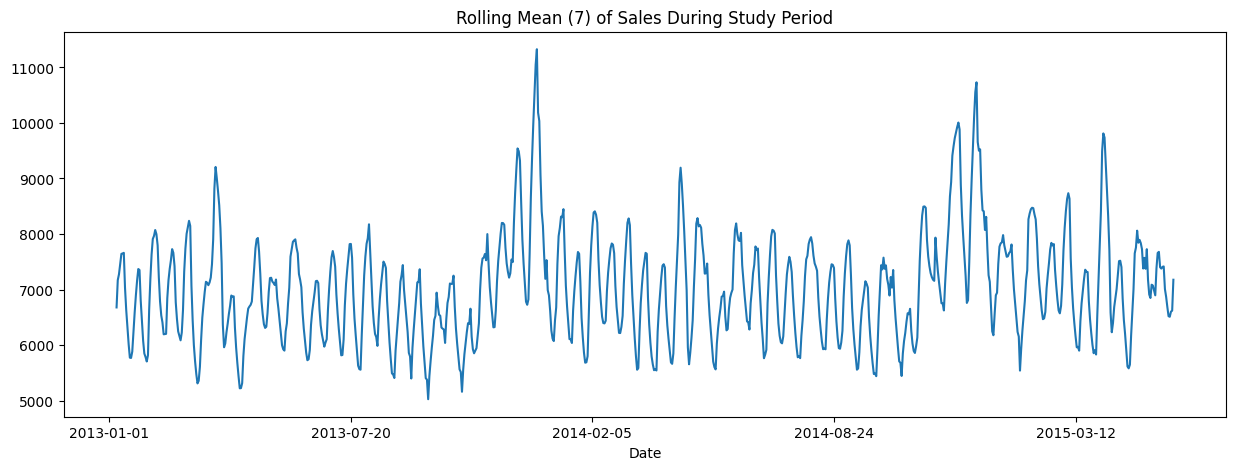

In [15]:
# time series by store
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
average_sales = sale_data.groupby('Date')["Sales"].mean()

# Plot average sales
average_sales.rolling(window=7).mean().plot(ax=axis1)
axis1.set_title('Rolling Mean (7) of Sales During Study Period')

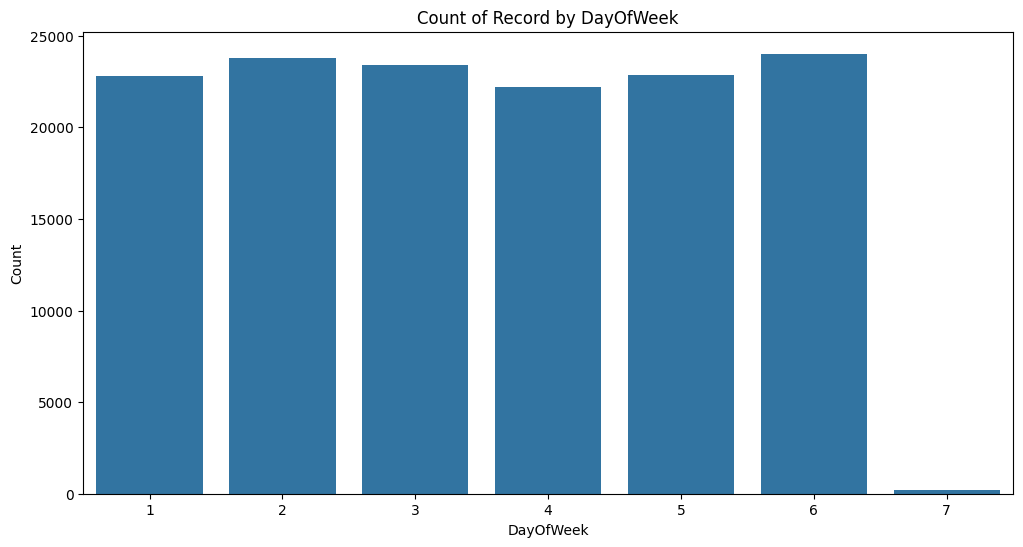

In [16]:
# Counter Plot
def CounterPlot(data, x):

    plt.figure(figsize=(12,6))

    counter_plot = sns.countplot(x= x, data=data)

    counter_plot.set_title(f'Count of Record by {x}')
    counter_plot.set_xlabel(x)
    counter_plot.set_ylabel('Count')
    return counter_plot

CounterPlot(sale_data, 'DayOfWeek')
plt.show()

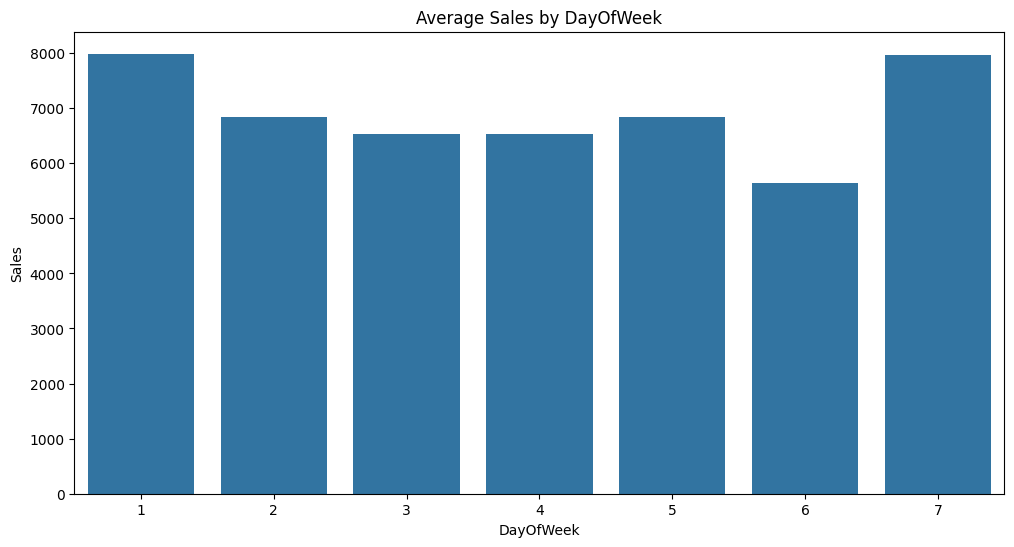

In [17]:
# More on Day Of Week
def BarPlot(data, x,y):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=x, y=y, data=data, errorbar=None)

    ax.set_title(f'Average {y} by {x}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return ax

BarPlot(sale_data, 'DayOfWeek', 'Sales')
plt.show()

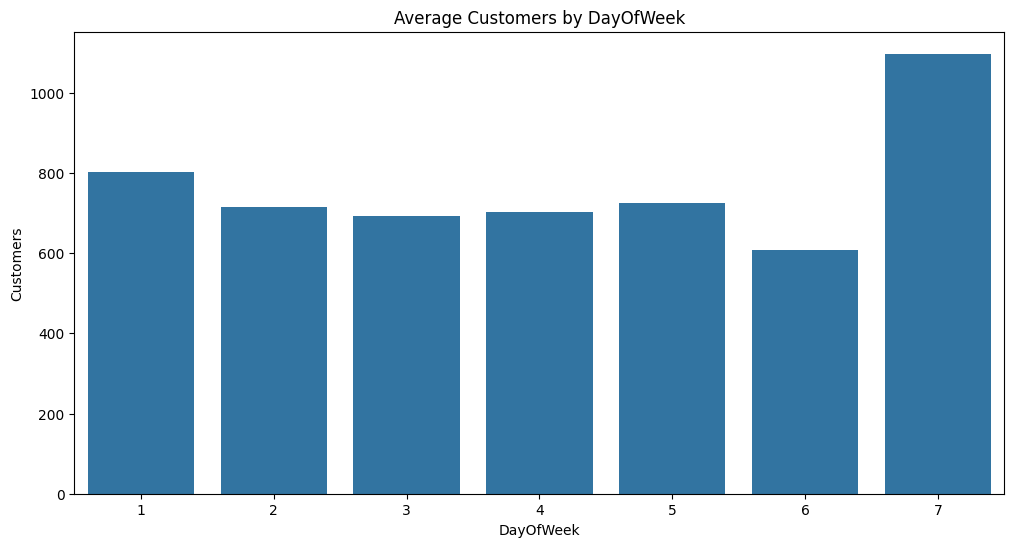

In [18]:
BarPlot(sale_data, 'DayOfWeek', 'Customers')
plt.show()

Does the Promotion effect the sales or customers in average?

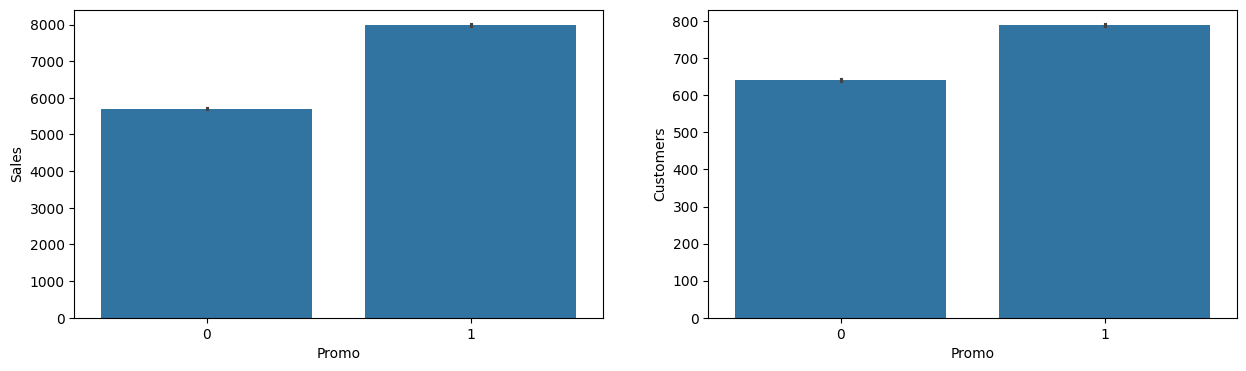

In [19]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
# we can check the error bar
sns.barplot(x='Promo', y='Sales', data=sale_data, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=sale_data, ax=axis2)

plt.show()

Since we only included store that open in certain day, we tend to have less records with `StateHoliday` != 0

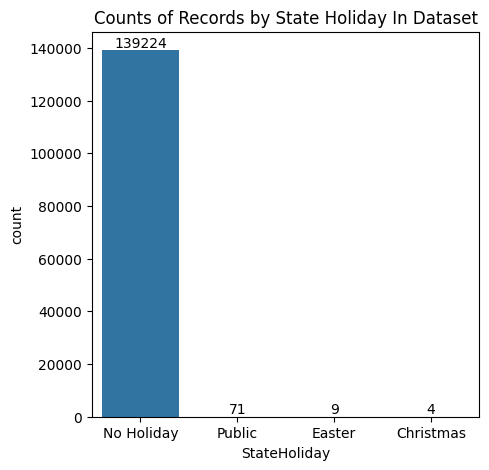

In [20]:
# State Holiday
fig, axis = plt.subplots(1,1,figsize=(5,5))
# StateHoliday column has values 0 & "0", So, we need to merge values with 0 to "0"
sale_data[sale_data["StateHoliday"] == 0] = "0"

sns.countplot(x='StateHoliday', data=sale_data, ax=axis)
axis.title.set_text("Counts of Records by State Holiday In Dataset")
axis.set_xticks(['0','a','b','c'], labels=['No Holiday','Public', 'Easter', 'Christmas'])

axis.bar_label(axis.containers[0])
plt.show()

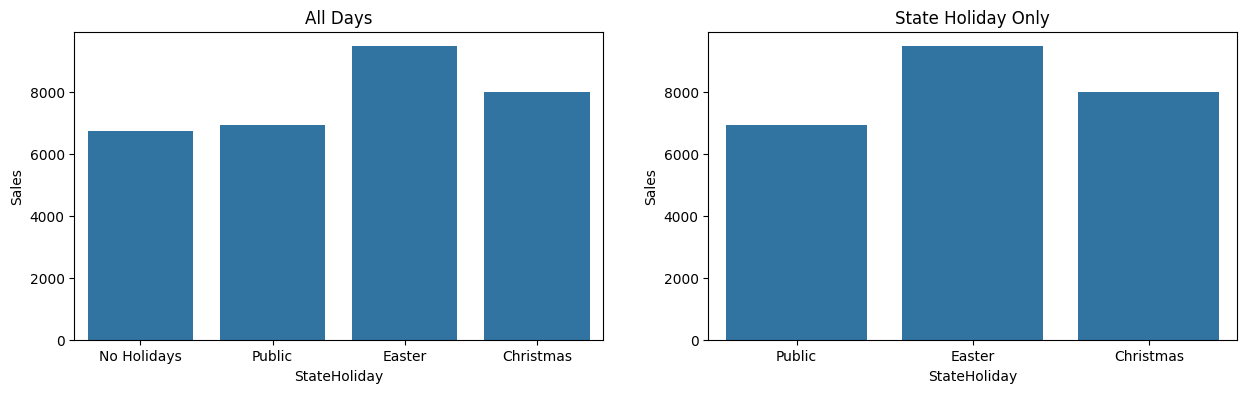

In [21]:
# StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=sale_data, ax=axis1, errorbar=None)
axis1.title.set_text("All Days")
axis1.set_xticks(['0','a','b','c'], labels=['No Holidays', 'Public', 'Easter', 'Christmas'])

mask = (sale_data["StateHoliday"] != "0") & (sale_data["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales',
            data=sale_data[mask], ax=axis2, errorbar=None)
axis2.title.set_text("State Holiday Only")
axis2.set_xticks(['a','b','c'], labels=['Public', 'Easter', 'Christmas'])
plt.show()

In [22]:
data = pd.merge(sale_data, store_data, on='Store')
data.head()

,Store,Date,DayOfWeek,Customers,Promo,StateHoliday,Sales,StoreType,CompetitionDistance
0,1,2015-06-01,1,607,1,0,5774,c,1270.0
1,2,2015-06-01,1,673,1,0,6629,a,570.0
2,3,2015-06-01,1,1012,1,0,11594,a,14130.0
3,4,2015-06-01,1,1695,1,0,13727,c,620.0
4,5,2015-06-01,1,778,1,0,8396,a,29910.0


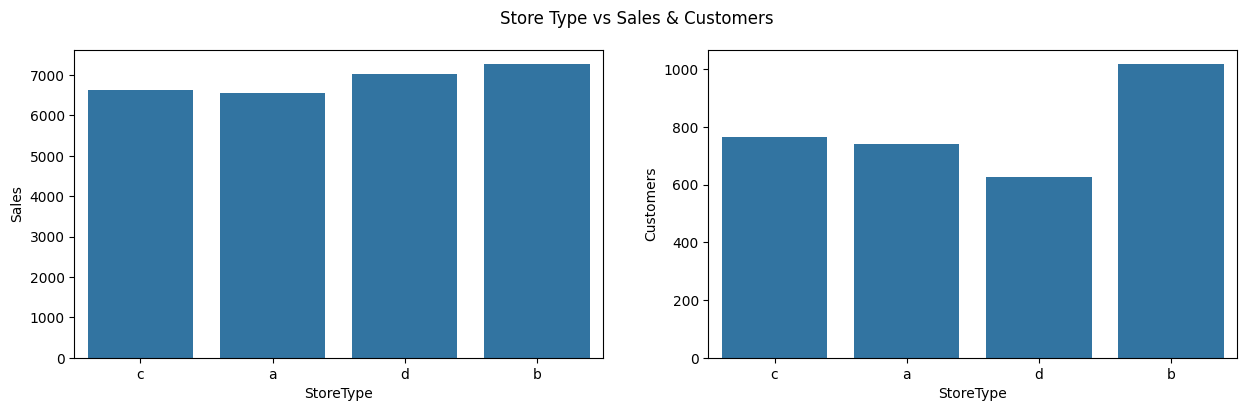

In [23]:
fig, axis = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=data, ax=axis[0], errorbar=None)
sns.barplot(x='StoreType', y='Customers', data=data, ax=axis[1], errorbar=None)

fig.suptitle("Store Type vs Sales & Customers")
plt.show()

Scatter Plot

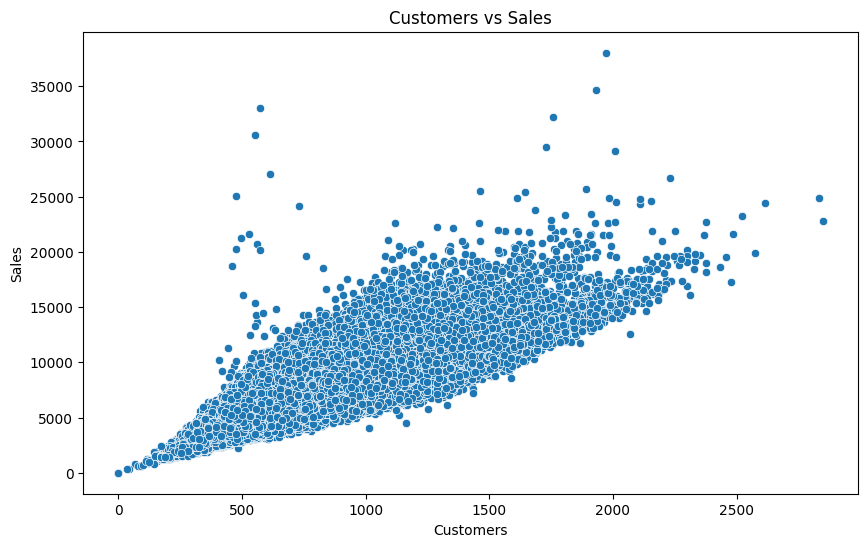

In [24]:
def ScatterPlot(data, x, y):

    plt.figure(figsize=(10, 6))

    scatter_plot = sns.scatterplot(x=x, y=y,
                     data=data)

    scatter_plot.set_title(f'{x} vs {y}')
    scatter_plot.set_xlabel(x)
    scatter_plot.set_ylabel(y)

    return scatter_plot

ScatterPlot(data, 'Customers', 'Sales')
plt.show()


## Data Preprocessing

### Missing Value

First, let’s check how many samples we have in the dataset.

In [25]:
data.shape

(139308, 9)

Checking which features have missing values

In [26]:
# check for missing values in each column
data.isnull().sum().to_dict()

{'Store': 0,
 'Date': 0,
 'DayOfWeek': 0,
 'Customers': 0,
 'Promo': 0,
 'StateHoliday': 0,
 'Sales': 0,
 'StoreType': 0,
 'CompetitionDistance': 2031}

Note that 2,642 records have missing values for `competition_distance`. Let's identify which stores have missing competition distance values.

In [27]:
data[data['CompetitionDistance'].isnull()]['Store'].unique()

array([291, 622, 879])

Assuming there are no competing stores near these locations, we can impute the missing `competition_distance` values using the maximum distance from the dataset.

In [28]:
data['CompetitionDistance'] = data['CompetitionDistance'].fillna(data['CompetitionDistance'].max())

In [29]:
data.isnull().sum()

Store                  0
Date                   0
DayOfWeek              0
Customers              0
Promo                  0
StateHoliday           0
Sales                  0
StoreType              0
CompetitionDistance    0
dtype: int64

Do all stores have records for every available date?

In [30]:
all_date = data['Date'].unique()
missing_date = len(all_date) - data[['Store', 'Date']].groupby('Store').count()
missing_date  = missing_date[missing_date['Date'] > 0]
missing_date.head()

,Date
Store,
1,152
2,150
3,154
4,150
5,155


In [31]:
missing_date.shape

(199, 1)

What are the missing dates?

In [32]:
dates_store_13 = data[data['Store'] == 13]['Date'].unique()
list(set(all_date) - set(dates_store_13))[0], list(set(all_date) - set(dates_store_13))[-1]

('2013-05-12', '2013-06-30')

41 stores are missing records from 2014-09-14 to 2014-12-19. If we treat each store as a time series, this could be an issue requiring imputation. However, in this lab, we treat each record as an individual sample, so we will not impute the missing data.

In [33]:
# You can choose to remove all the stores that are closed

# data = data[data['Open'] == 1]
# # Remove the open column
# data = data.drop(['Open'], axis=1)
# data.shape

### Feature Engineering

Feature engineering is a crucial step in the data preprocessing pipeline, where we transform raw data into meaningful features that improve the performance of our models.

Let's first check the data type of each features

In [34]:
data.dtypes

Store                    int64
Date                    object
DayOfWeek                int64
Customers                int64
Promo                    int64
StateHoliday            object
Sales                    int64
StoreType               object
CompetitionDistance    float64
dtype: object

#### Converting Date into Year, Month, and Day

Converting `date` feature into separate features for year, month, and day can be valuable. This process helps capture temporal patterns and seasonal effects in a more granular way.

In [35]:
data['Year'] = data['Date'].apply(lambda x: int(x.split('-')[0]))
data['Month'] = data['Date'].apply(lambda x: int(x.split('-')[1]))
data['DayOfMonth'] = data['Date'].apply(lambda x: int(x.split('-')[2]))

In [36]:
data.head()

,Store,Date,DayOfWeek,Customers,Promo,StateHoliday,Sales,StoreType,CompetitionDistance,Year,Month,DayOfMonth
0,1,2015-06-01,1,607,1,0,5774,c,1270.0,2015,6,1
1,2,2015-06-01,1,673,1,0,6629,a,570.0,2015,6,1
2,3,2015-06-01,1,1012,1,0,11594,a,14130.0,2015,6,1
3,4,2015-06-01,1,1695,1,0,13727,c,620.0,2015,6,1
4,5,2015-06-01,1,778,1,0,8396,a,29910.0,2015,6,1


#### Categorical Variables

We will create binary columns for each category by converting categorical features (with `string` or `object` data types) into binary features using one-hot encoding. Additionally, we will discuss other numerical features that may also require one-hot encoding in the later sections.



In [37]:
#split StateHoliday into 4 variables
data = pd.concat([data, pd.get_dummies(data['StateHoliday'], prefix='StateHoliday',dtype=int)], axis=1)
data.drop('StateHoliday', axis=1, inplace=True)
# split StoreType into 4 variables
data = pd.concat([data, pd.get_dummies(data['StoreType'], prefix='StoreType',dtype=int)], axis=1)
data.drop('StoreType', axis=1, inplace=True)

In [38]:
data.head()

,Store,Date,DayOfWeek,Customers,Promo,Sales,CompetitionDistance,Year,Month,DayOfMonth,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,1,2015-06-01,1,607,1,5774,1270.0,2015,6,1,1,0,0,0,0,0,1,0
1,2,2015-06-01,1,673,1,6629,570.0,2015,6,1,1,0,0,0,1,0,0,0
2,3,2015-06-01,1,1012,1,11594,14130.0,2015,6,1,1,0,0,0,1,0,0,0
3,4,2015-06-01,1,1695,1,13727,620.0,2015,6,1,1,0,0,0,0,0,1,0
4,5,2015-06-01,1,778,1,8396,29910.0,2015,6,1,1,0,0,0,1,0,0,0


"Note that if `StateHoliday_0 = 1`, it indicates that `StateHoliday_a`, `StateHoliday_b`, and `StateHoliday_c` must all be 0, and vice versa. This creates a high correlation between these features, which can negatively impact the performance of some models. To avoid this issue, we should remove the `StateHoliday_0` feature from the dataset.

In [39]:
data = data.drop(['StateHoliday_0'], axis=1)
#replace the column names of the StateHoliday columns into the actual names
data.columns = data.columns.str.replace('StateHoliday_a', 'Public')
data.columns = data.columns.str.replace('StateHoliday_b', 'Easter')
data.columns = data.columns.str.replace('StateHoliday_c', 'Christmas')

In [40]:
data.dtypes

Store                    int64
Date                    object
DayOfWeek                int64
Customers                int64
Promo                    int64
Sales                    int64
CompetitionDistance    float64
Year                     int64
Month                    int64
DayOfMonth               int64
Public                   int64
Easter                   int64
Christmas                int64
StoreType_a              int64
StoreType_b              int64
StoreType_c              int64
StoreType_d              int64
dtype: object

We will keep the Date feature for now to facilitate the addition of new features. This will help us to more easily extract and work with temporal information as we proceed with feature engineering.

#### Creating New features

We may create new features based on existing ones to capture additional information or interactions that could be beneficial for model performance.

For instance, you can create features that represent the average number of customers over the past month or week. Additionally, you might calculate the number of days since the last promotion.


In [41]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    '''
    This function will create additional features from the existing dataset
    '''
    data_with_additional_features = pd.DataFrame()
    for i in data['Store'].unique():

        a = data[data['Store']==i]
        a = a.sort_values('Date')

        # Day of the Year
        a['Date'] = pd.to_datetime(a['Date'], format='%Y-%m-%d')
        a['DayOfYear'] = a['Date'].dt.dayofyear

        a.sort_values('Date', inplace=True)
        # find the rolling mean of Customer for the last 7 days
        a['WeeklyRollingMean'] = a['Customers'].rolling(7).mean()
        #the first 7 days will be missing
        a['WeeklyRollingMean'] = a['WeeklyRollingMean'].bfill()

        # find the rolling mean for the last 30 days
        a['MonthlyRollingMean'] = a['Customers'].rolling(30).mean()
        a['MonthlyRollingMean'] = a['MonthlyRollingMean'].bfill()

        #How many days since the last promotion (Promo = True)
        a['DaysSinceLastPromo'] = 0
        day_without_promo = 0
        for i in a['Date']:
            if a.loc[a['Date']==i, 'Promo'].values[0] == 1:
                a.loc[a['Date']==i, 'DaysSinceLastPromo'] = 0
                day_without_promo = 0
            else:
                day_without_promo += 1
                a.loc[a['Date']==i, 'DaysSinceLastPromo'] = day_without_promo

        data_with_additional_features = pd.concat([data_with_additional_features, a])
    return data_with_additional_features

data_with_additional_features = add_features(data)



In [42]:
data_with_additional_features.sort_index().head()

,Store,Date,DayOfWeek,Customers,Promo,Sales,CompetitionDistance,Year,Month,DayOfMonth,...,Easter,Christmas,StoreType_a,StoreType_b,StoreType_c,StoreType_d,DayOfYear,WeeklyRollingMean,MonthlyRollingMean,DaysSinceLastPromo
0,1,2015-06-01,1,607,1,5774,1270.0,2015,6,1,...,0,0,0,0,1,0,152,525.714286,532.933333,0
1,2,2015-06-01,1,673,1,6629,570.0,2015,6,1,...,0,0,1,0,0,0,152,549.571429,594.900000,0
2,3,2015-06-01,1,1012,1,11594,14130.0,2015,6,1,...,0,0,1,0,0,0,152,686.714286,764.533333,0
3,4,2015-06-01,1,1695,1,13727,620.0,2015,6,1,...,0,0,0,0,1,0,152,1404.428571,1371.800000,0
4,5,2015-06-01,1,778,1,8396,29910.0,2015,6,1,...,0,0,1,0,0,0,152,510.000000,550.233333,0




To enhance the model, we can incorporate external datasets that provide additional context or insights. For example:

- **Weather Data for Different States:** Access historical weather data, which might influence store sales, from [here](https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17058#97075).
- **Mapping of Stores to States:** Use a dataset that maps stores to their respective states, available [here](https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17048).
- **Macro Indicators:** Integrate macroeconomic indicators to account for broader economic factors impacting sales. Find relevant datasets [here](https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17111).
- **Google Trends Data for 'Rossmann':** Analyze Google Trends data related to 'Rossmann' to gauge public interest and its potential impact on sales, available [here](https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17130#97196).



For example, we can integrating weather data, which can provide valuable context for understanding patterns in your data. Key weather features to consider include:

- Mean Temperature: The average temperature on a given date, which can influence consumer behavior and store sales.
- Rain Presence: A precentage of whether it rained on that date, as weather conditions like rain can affect foot traffic and sales.
- Wind Speed: The average wind speed on that date, which might also impact store performance, especially in outdoor locations.

In [43]:
store_to_states = pd.read_csv(DATA_DIR +'/store_states.csv')
weather_data = pd.read_csv(DATA_DIR +'/weather_data.csv')
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%Y-%m-%d')

In [44]:
store_to_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [45]:
weather_data.head()

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,State
0,2013-01-01,7,5,3,4,0,-2,81,68,46,...,17.0,10.0,26,19,NaN,0.00,7.0,Rain,183,SN
1,2013-01-02,5,3,2,4,1,-1,93,78,60,...,13.0,10.0,29,18,40.0,0.00,6.0,Rain,251,SN
2,2013-01-03,8,6,3,7,3,-1,93,80,60,...,14.0,7.0,35,23,48.0,3.05,6.0,Rain,250,SN
3,2013-01-04,9,8,7,8,6,4,100,87,73,...,12.0,3.0,40,23,61.0,4.06,6.0,Rain,289,SN
4,2013-01-05,7,6,5,7,6,4,100,94,86,...,7.0,3.0,35,24,53.0,0.76,7.0,Rain,327,SN


In [46]:
weather_data.columns

Index(['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'State'],
      dtype='object')

Mapping each store to its states, and then obtaining the states' weather in each specific date

In [47]:
def add_external_data(data: pd.DataFrame, store_mapper: pd.DataFrame, external_data: pd.DataFrame,
                      external_feature: list) -> pd.DataFrame:
    '''
    This function will add external data to the existing dataset
    '''
    data_with_external = pd.merge(data, store_mapper, on='Store')
    data_with_external = pd.merge(data_with_external,
                                  weather_data[['Date', 'State'] + external_feature],
                                  on=['Date', 'State'])
    return data_with_external

data_with_external = add_external_data(data_with_additional_features,
                                       store_to_states, weather_data,
                                       ['Mean_TemperatureC', 'Mean_Wind_SpeedKm_h', 'Precipitationmm'])

In [48]:
# drop unnecessary columns (or you can create indicator variables to keep them)
data.drop('Date', axis=1, inplace=True)
data_with_external.drop('Date', axis=1, inplace=True)
data_with_external.drop('State', axis=1, inplace=True)

Checking if there is missing value in our external dataset

In [49]:
data_with_external.isnull().sum()

Store                  0
DayOfWeek              0
Customers              0
Promo                  0
Sales                  0
CompetitionDistance    0
Year                   0
Month                  0
DayOfMonth             0
Public                 0
Easter                 0
Christmas              0
StoreType_a            0
StoreType_b            0
StoreType_c            0
StoreType_d            0
DayOfYear              0
WeeklyRollingMean      0
MonthlyRollingMean     0
DaysSinceLastPromo     0
Mean_TemperatureC      0
Mean_Wind_SpeedKm_h    0
Precipitationmm        0
dtype: int64

### Correlation and mutural information

In correlation analysis, certain columns (e.g., Store ID, DayOfWeek, DayOfMonth) are unsuitable for inclusion as they do not reflect meaningful linear relationships with the target feature, sales.

For instance, in the case of DayOfWeek, the arbitrary assignment of the first and last days complicates interpretation, as reordering these IDs can significantly alter the correlation results, making them unreliable. By contrast, Year can be retained when there is an expected linear trend in sales over time.

While one-hot encoding could be considered for categorical IDs, it would result in a highly complex and impractical correlation matrix. Therefore, we decided to drop these fields to avoid introducing misleading correlations with other numeric variables.

In [50]:
feature_for_correlation_analysis = ['Customers', 'CompetitionDistance', 'Promo',
                                    'Public', 'Easter', 'Christmas', 'StoreType_a',
                                    'StoreType_b', 'StoreType_c', 'StoreType_d', 'Year',
                                    'Month', 'WeeklyRollingMean','MonthlyRollingMean', 'DaysSinceLastPromo', 
                                    'Mean_TemperatureC','Mean_Wind_SpeedKm_h', 'Precipitationmm']

<Axes: >

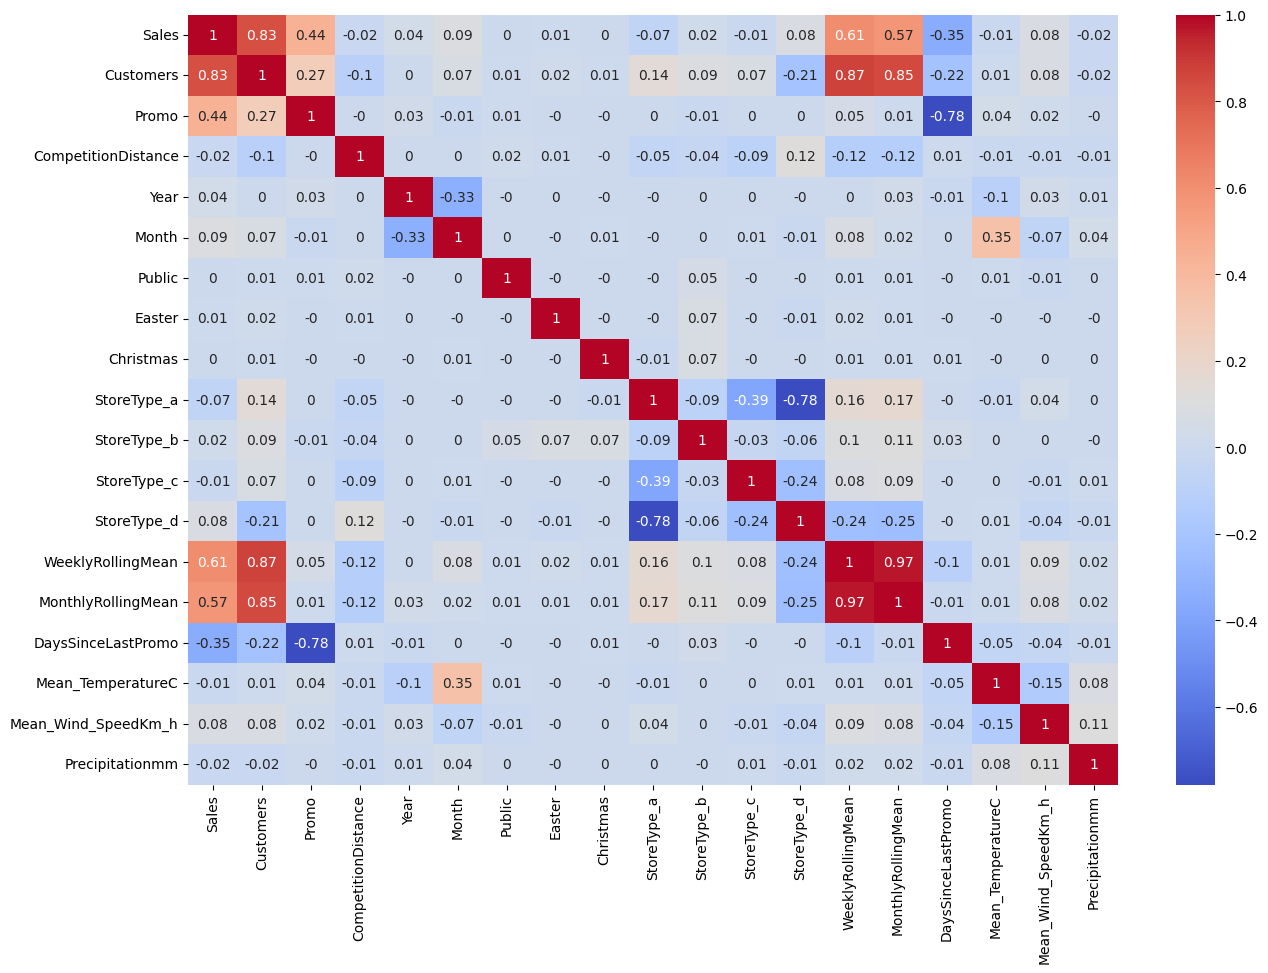

In [51]:
#correlation matrix
feature_for_correlation = data_with_external[['Sales'] + [col for col in data_with_external.columns if col in feature_for_correlation_analysis]]
corr = feature_for_correlation.corr()
corr = np.round(corr, 2)
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

Mutual Information (MI) quantifies the amount of shared information between two variables. It is particularly useful for identifying which features contribute the most relevant information about the target feature `Sales`, helping in the selection of features that are both informative and non-redundant.

In `sklearn`, the `mutual_info_score` function calculates MI effectively for categorical variables. As stated in the documentation "this metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way," it avoids the issues previously encountered with correlation, where arbitrary numeric assignments affected reliability.

(Reference: [mutual_info_score in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html))

In [52]:
# Mutual Information
from sklearn.metrics import mutual_info_score
mi = data.apply(lambda x: mutual_info_score(x, data['Sales']), axis=0)
mi = mi.sort_values(ascending=False)
mi

Sales                  9.110537
Customers              4.150762
Store                  2.652884
CompetitionDistance    2.500057
DayOfMonth             1.051083
Month                  0.501325
DayOfWeek              0.291715
Promo                  0.170891
Year                   0.106778
StoreType_a            0.065518
StoreType_d            0.062517
StoreType_c            0.047601
StoreType_b            0.015209
Public                 0.002806
Easter                 0.000550
Christmas              0.000223
dtype: float64

MI with all features

In [53]:
mi_all = data_with_external.apply(lambda x: mutual_info_score(x, data_with_external['Sales']), axis=0)
mi_all = mi_all.sort_values(ascending=False)
mi_all

/Users/joeliang/miniforge3/envs/native/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/joeliang/miniforge3/envs/native/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/joeliang/miniforge3/envs/native/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


Sales                  9.110537
MonthlyRollingMean     7.175809
WeeklyRollingMean      5.925197
Customers              4.150762
DayOfYear              3.133208
Store                  2.652884
CompetitionDistance    2.500057
DayOfMonth             1.051083
Mean_TemperatureC      0.986112
Mean_Wind_SpeedKm_h    0.620807
Month                  0.501325
DaysSinceLastPromo     0.428538
Precipitationmm        0.376148
DayOfWeek              0.291715
Promo                  0.170891
Year                   0.106778
StoreType_a            0.065518
StoreType_d            0.062517
StoreType_c            0.047601
StoreType_b            0.015209
Public                 0.002806
Easter                 0.000550
Christmas              0.000223
dtype: float64


## Training and Validation Set

![image](https://codingnomads.com/images/f8c470c9-c714-48e6-0397-7a9a4e57b500/public)

In [54]:
np.random.seed(0)

X = data_with_external.drop('Sales', axis=1)
y = data_with_external['Sales']

# Split the data into train and validation using 80% of the data for training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [55]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((111446, 22), (111446,), (27862, 22), (27862,))

## Model Training

In this lab, we will explore sales prediction using two key models: linear regression and gradient boosting. Linear regression provides high interpretability through its coefficients and parameters, making it easier to understand how features affect predictions. Gradient boosting, on the other hand, allows for the training of more complex models that better capture real-world scenarios.

In addition to these, there are several other regression models available in `sklearn` for sales prediction, such as **Support Vector Regression**, **Gaussian naive Bayes**, and decision trees. Feel free to explore these models if you're interested in experimenting further.

(Reference: [scikit-learn - Supervised Learning](https://scikit-learn.org/stable/supervised_learning.html))


## Linear Regression

### Original Features
First, we’ll fit a simple linear regression model using Ordinary Least Squares (OLS) with all the original variables. This approach involves finding the line of best fit by minimizing the sum of the squared differences between the observed features and `Sales`. We will use the training dataset to determine the relationship between the predictor variables and the target variable.

However, directly applying categorical variables such as Store ID, DayOfWeek, DayOfMonth, and Year in linear regression without one-hot encoding presents the same issue we encountered in correlation analysis. To avoid this and improve interpretability, we will first drop these features and then reintroduce them using one-hot encoding.

In [171]:
#linear regression
feature = ['Customers', 'Promo',
       'CompetitionDistance', 'Year', 'DayOfMonth', 'Public',
       'Easter', 'Christmas', 'StoreType_a','StoreType_b', 'StoreType_c', 'StoreType_d']

X_train_original = X_train[feature]
X_val_original = X_val[feature]

model = linear_model.LinearRegression()
model.fit(X_train_original, y_train)

LinearRegression()

We can examine the coefficients of each feature in the linear regression model to understand the impact of each variable on the target variable. By analyzing these coefficients, we can gain insights into how features influence the sales of each store.

In [57]:
# cofficients
model.coef_

array([ 7.92825350e+00,  1.10148349e+03,  7.63340828e-03,  1.18557349e+02,
        9.81060784e-01, -6.56099115e+02, -8.35660383e+02,  1.28686166e+03,
        2.24422381e+01, -1.33117464e+03, -8.06032234e+01,  1.38933563e+03])

In [58]:
model.intercept_

-238633.63946994045

What does these coeffcient tell us?

In [59]:
pd.DataFrame(model.coef_, index=X_train_original.columns, columns=['Coefficients'])

,Coefficients
Customers,7.928253
Promo,1101.483491
CompetitionDistance,0.007633
Year,118.557349
DayOfMonth,0.981061
Public,-656.099115
Easter,-835.660383
Christmas,1286.861662
StoreType_a,22.442238
StoreType_b,-1331.174645


Be very cautious when interpreting feature weight signs in linear regression. The weights are not learned independently; therefore, a feature with a strong positive correlation may end up with a negative weight. This can occur because it counteracts the effects of another correlated feature. It’s essential to consider the relationships between features and their combined impact on the model rather than relying solely on the individual signs of the weights.


Now, let’s use the linear regression model we just trained to make predictions on the validation set. This will allow us to assess how well our model performs on unseen data by comparing the predicted sales values to the actual sales values in the validation set.

In [60]:
# predicting the sales using the validation set
y_pred = model.predict(X_val_original)

In [61]:
X_val_original.iloc[0], y_val.iloc[0], y_pred[0]

(Customers               466.0
 Promo                     0.0
 CompetitionDistance    9710.0
 Year                   2013.0
 DayOfMonth                5.0
 Public                    0.0
 Easter                    0.0
 Christmas                 0.0
 StoreType_a               0.0
 StoreType_b               0.0
 StoreType_c               0.0
 StoreType_d               1.0
 Name: 31093, dtype: float64,
 5566,
 5185.231911794894)

Let’s compare the actual sales values with the predicted sales values from our model. This comparison helps us identify any discrepancies between the predictions and the actual outcomes, and provides insights into the model’s accuracy and areas where it might need improvement.

![image](https://miro.medium.com/v2/resize:fit:820/format:webp/1*137-_vGGaEPEMgzDRxPO9Q.png)

In [62]:
residual = pd.DataFrame({'Store': X_val['Store'],
              'Date': X_val['Year'].astype(str) + '-' + X_val['Month'].astype(str) + '-' + X_val['DayOfMonth'].astype(str),
              'Actual Sales': y_val, 'Predicted Sales': y_pred, 'Residuals': y_val - y_pred})
residual.head()

,Store,Date,Actual Sales,Predicted Sales,Residuals
31093,45,2013-1-5,5566,5185.231912,380.768088
25176,36,2014-1-31,9961,8712.783224,1248.216776
25426,37,2013-1-7,7795,7694.504882,100.495118
31459,45,2014-3-21,5831,6095.911331,-264.911331
80008,114,2014-11-12,5265,5727.045965,-462.045965


Which prediction has the highest residual

In [63]:
residual.sort_values('Residuals', ascending=False).head()

,Store,Date,Actual Sales,Predicted Sales,Residuals
88332,126,2013-9-9,24134,8343.231015,15790.768985
86440,123,2014-8-18,29501,15118.332850,14382.667150
88335,126,2013-9-12,20701,7006.299356,13694.700644
88364,126,2013-10-17,18697,5085.182805,13611.817195
86441,123,2014-8-19,24916,14175.851744,10740.148256


In [64]:
def retrieve_sample(df, store, date):
    Year, Month, Day = date.split('-')
    return df[(df['Store'] == store) & (df['Year'] == int(Year)) &
              (df['Month'] == int(Month)) & (df['DayOfMonth'] == int(Day))]

retrieve_sample(X_val, 126, '2013-9-9')

,Store,DayOfWeek,Customers,Promo,CompetitionDistance,Year,Month,DayOfMonth,Public,Easter,...,StoreType_b,StoreType_c,StoreType_d,DayOfYear,WeeklyRollingMean,MonthlyRollingMean,DaysSinceLastPromo,Mean_TemperatureC,Mean_Wind_SpeedKm_h,Precipitationmm
88332,126,1,731,1,3370.0,2013,9,9,0,0,...,0,0,1,252,528.714286,537.3,0,14,10,6.1


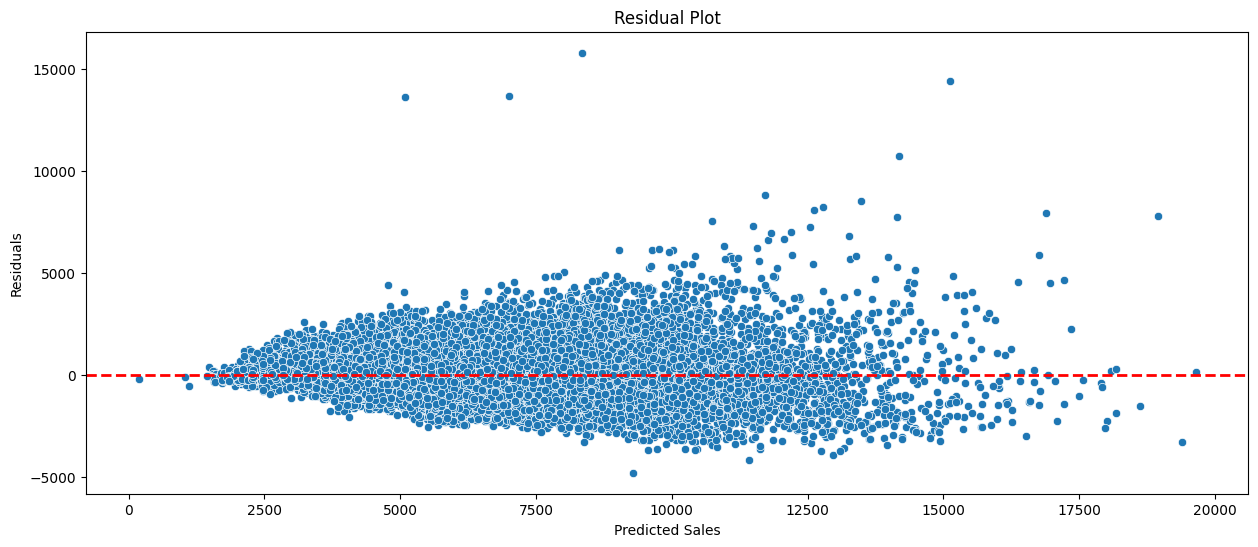

In [65]:
def plot_residual(y_val, y_pred):
    fig, axis = plt.subplots(1,1,figsize=(15,6))
    sns.scatterplot(x=y_pred, y=y_val-y_pred, ax=axis)
    axis.axhline(0, color='red', linestyle='dashed', linewidth=2)
    axis.title.set_text("Residual Plot")
    axis.set_xlabel("Predicted Sales")
    axis.set_ylabel("Residuals")
    plt.show()

plot_residual(y_val, y_pred)

A few characteristics of a good residual plot are as follows:

- It has a high density of points close to the origin and a low density of points away from the origin
- It is symmetric about the origin
- that independent of the value of an independent variable (x-axis), the residual errors are approximately distributed in the same manner

We can use metrics, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) to eveluate the performance of our model in the entire validation dataset

1. **Mean Absolute Error (MAE)**:
$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$

2. **Mean Squared Error (MSE)**:
$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

3. **Root Mean Squared Error (RMSE)**:
$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$

Where:
- $ y_i $ is the actual sale.
- $ \hat{y}_i $ is the predicted sale.
- $ n $ is the number of record in the validation dataset.

In [66]:
def eveluate_model(y_true, y_pred):
    mae= mean_absolute_error(y_true = y_true, y_pred = y_pred)
    mse = mean_squared_error(y_true= y_true, y_pred = y_pred)
    rmse = root_mean_squared_error(y_true= y_true, y_pred = y_pred)
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    return mae, mse, rmse

mae, mse, rmse = eveluate_model(y_val, y_pred)

Mean Absolute Error: 836.587797881109
Mean Squared Error: 1279680.1832105624
Root Mean Squared Error: 1131.2295006808133


Sometimes, using a single validation dataset may not be sufficient to accurately evaluate the performance of a model. In such cases, cross-validation can be a more robust technique, as it allows us to assess the model’s performance across multiple subsets of the data. This helps to ensure that the model generalizes well and isn’t overly dependent on any single training or validation split.

![image](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [67]:
cv_result = cross_val_score(model, X[feature], y, cv=5,
                            scoring='neg_root_mean_squared_error')

cv_result

array([-1125.82241994, -1217.96974543, -1143.58621055, -1236.23006151,
       -1103.88822356])

In [68]:
rmse = np.mean(-cv_result)
rmse

1165.4993321977738

In [172]:
# here is a complete function to perform cross validation and return the mean RMSE with 95% CI
def cross_val(model, X, y, cv=10, verbose=True):
    cv_result = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    for split in range(cv):
        if verbose:
            print(f'Split {split+1}: {-cv_result[split]}')

    mean = np.mean(-cv_result)
    sem = stats.sem(-cv_result)
    stats.t.interval(0.95, len(data)-1, loc=mean, scale=sem)
    if verbose:
        print(f'Mean RMSE with 95% CI: {np.mean(-cv_result)} +/- {stats.sem(-cv_result)}')
    return np.mean(-cv_result)

rmse_original = cross_val(model, X[feature], y, cv=5)

Split 1: 1125.8224199438546
Split 2: 1217.9697454315553
Split 3: 1143.5862105492884
Split 4: 1236.230061509098
Split 5: 1103.8882235550718
Mean RMSE with 95% CI: 1165.4993321977738 +/- 26.082897949044096


### One Hot Encoding Additional Categorical Features

Now, let’s add back all the categorical features to our training set. Use one-hot encoding to transform the categorical variables into numerical features. 

In [70]:
data.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Promo', 'Sales',
       'CompetitionDistance', 'Year', 'Month', 'DayOfMonth', 'Public',
       'Easter', 'Christmas', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d'],
      dtype='object')

In [71]:
# all original features in the dataset
features = ['Store', 'DayOfWeek', 'Customers', 'Promo',
       'CompetitionDistance', 'Year', 'Month', 'Public',
       'Easter', 'Christmas', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d']

# create a new feature set with one hot encoding
X_with_one_hot = X[features].copy()

# one hot encoding for Store, DayOfWeek, and Month
X_with_one_hot = pd.get_dummies(X_with_one_hot, columns=['Store', 'DayOfWeek', 'Month'], dtype=int)

#replace the column name of the DayOfWeek columns into the weekday names
mapper_week = {'DayOfWeek_1': 'Monday', 'DayOfWeek_2': 'Tuesday', 'DayOfWeek_3': 'Wednesday',
            'DayOfWeek_4': 'Thursday', 'DayOfWeek_5': 'Friday', 'DayOfWeek_6': 'Saturday',
            'DayOfWeek_7': 'Sunday'}
X_with_one_hot.rename(columns=mapper_week,inplace=True)
# replace the column name of the Month columns into the month names
mapper_month = {'Month_1': 'January', 'Month_2': 'February', 'Month_3': 'March',
            'Month_4': 'April', 'Month_5': 'May', 'Month_6': 'June',
            'Month_7': 'July', 'Month_8': 'August', 'Month_9': 'September',
            'Month_10': 'October', 'Month_11': 'November', 'Month_12': 'December'}
X_with_one_hot.rename(columns=mapper_month, inplace=True)

#drop one of the columns to avoid multicollinearity
X_with_one_hot.drop(['Monday', 'January', 'Store_1'], axis=1, inplace=True)

X_with_one_hot.head()

,Customers,Promo,CompetitionDistance,Year,Public,Easter,Christmas,StoreType_a,StoreType_b,StoreType_c,...,March,April,May,June,July,August,September,October,November,December
0,668,0,1270.0,2013,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,578,0,1270.0,2013,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,619,0,1270.0,2013,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,635,0,1270.0,2013,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,785,1,1270.0,2013,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [72]:
model = linear_model.LinearRegression()
rmse_one_hot = cross_val(model, X_with_one_hot, y, cv=5)

Split 1: 1367.4508194597404
Split 2: 2749163886.5379715
Split 3: 21382093776.95837
Split 4: 1398.5967808390303
Split 5: 1138.753020350005
Mean RMSE with 95% CI: 4826252313.659393 +/- 4173058107.5883565


Did you notice any problems?

- Sparse features can lead to uneven distributions across different folds, leading to overfitting in folds where there is less relevant information.

- Too sparse features can also cause overfitting since linear regression tends to fit noise if there are too many features relative to the number of data points.


### Learning Curve

To investigate issues within the trained model, we can use a learning curve, which measures the model's performance across different values (typically ranging from small to large) of key indicators, such as training time, model complexity, and sample size. By plotting the model's RMSE (Root Mean Squared Error) on the validation set, we can assess its behavior in relation to:

- The amount of training time
- Model complexity (e.g., number of features/parameters or regularization strength) — this is one of the most commonly used indicators
- The amount of training data used

These plots provide insights into how the model's performance evolves and help identify underfitting or overfitting trends.

#### Learning Curve with Epoches

The most commonly used learning curve plot illustrates the training versus validation error across various numbers of epochs, where an epoch refers to a complete pass through the training dataset when using grident descent to estimate the model weight (or coefficents in this case).

However, the Linear Regression model in sklearn does not utilize gradient descent; instead, it directly computes the solution using the matrix inverse method (similar to what you encountered in the Q7 of the Python warm-up assignment).

We will discuss Learning Curve with epoches in the later section. But you can use the `SGDRegressor` in sklearn, which employs stochastic gradient descent to estimate the coefficients. This approach allows us to observe how the model’s performance evolves over epochs as it learns from the training data. However, we cannot plot validation errors across different epochs in  `SGDRegressor`. You can also check `liblinear` package, or `Pytorch` linear layer for more information on applying graident descent techniques in linear regression model. 

#### Learning Curve with Training Dataset Size

We can also visualize the RMSE with varying training dataset sizes. The `learning_curve` function in `sklearn` helps achieve this by splitting the data into subsets of different sizes (ranging from small to large) and training the model on each subset. By plotting the RMSE against the size of the training data, you can visualize the learning curve, which provides insights into how the model's performance improves as it is exposed to more data.

![image](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/model_selection/1.png)

Regime 1 (High Variance)

Regime 2 (High Bias)

https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html

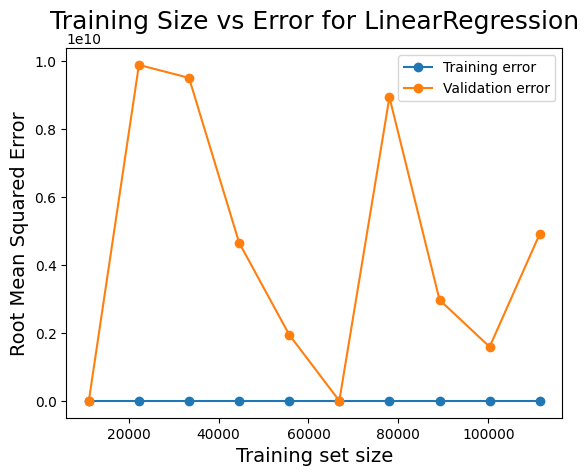

In [89]:
def plot_learning_curve_size(X, y, model, cv = 10, train_sizes=np.linspace(0.1, 1.0, 10),
                        scoring = 'neg_root_mean_squared_error'):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
        X = X, y = y, cv = cv,
        train_sizes=train_sizes,
        scoring = scoring)

    plt.plot(train_sizes, -train_scores.mean(axis = 1), label = 'Training error', marker = 'o')
    plt.plot(train_sizes, -validation_scores.mean(axis = 1), label = 'Validation error', marker = 'o')
    plt.ylabel(' '.join(scoring.split('_')[1:]).title(), fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(f'Training Size vs Error for {model.__class__.__name__}', fontsize = 18, y = 1.03)
    plt.legend()

model = linear_model.LinearRegression()
plot_learning_curve_size(X_with_one_hot, y, model, cv = 5)

In the “Error vs. Training Set Size” plot, we observe that without regularization, the model’s performance on the training data is highly susceptible to individual data points. This indicates overfitting, where the model learns the specific patterns and noise within the training data instead of generalizing well to unseen data. As a result, the training error remains low, while the test error tends to remain high, highlighting the need for regularization to balance this trade-off and improve generalization.

### Regularization: Ridge and Lasso Regression
Sometime, regularization can helps us avoid overfitting of the data, especially when there is a large variance between train and validation set performances. Lasso and Ridge are two most commonly used regularizations

- Ridge Regression (L2 regularization):
$\min_{\beta} \left( \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^{p} \beta_j^2 \right)$

- Lasso Regression (L1 regularization):
$
\min_{\beta} \left( \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right)
$

where

- $ y_i $: The target variable (Sales) in the ith records
- $ X_i $: The feature values in the ith records
- $ p $: The number of features.

- $ \beta_j $: The $j$-th coefficient in the vector $ \beta $.
- $ \beta $: The vector of coefficients (or weights) to be estimated.

- $ \alpha $: The regularization parameter that controls the penalty strength.

In [76]:
model_ridge = linear_model.Ridge(alpha=0.5)
rmse_ridge = cross_val(model_ridge, X_with_one_hot, y, cv=5)

Split 1: 1366.0904889805938
Split 2: 1260.33128625643
Split 3: 1256.1250533339714
Split 4: 1397.4720332647614
Split 5: 1137.9839756882056
Mean RMSE with 95% CI: 1283.6005675047925 +/- 45.973825705749405


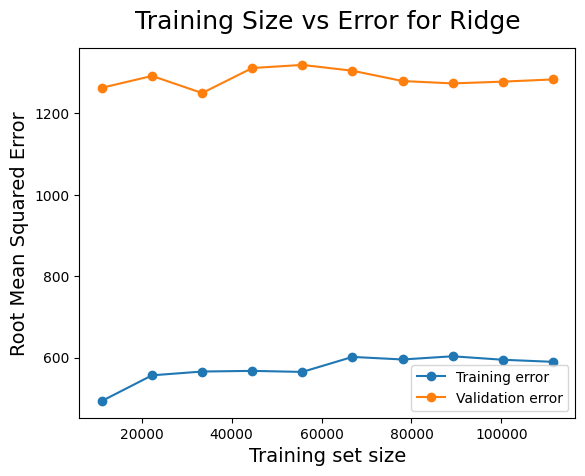

In [90]:
plot_learning_curve_size(X_with_one_hot, y, model_ridge, cv = 5)
plt.show()

In [78]:
model_lasso = linear_model.Lasso(alpha=0.5)
rmse_lasso = cross_val(model_lasso, X_with_one_hot, y, cv=5)

Split 1: 1298.8622087814024
Split 2: 1238.033155023579
Split 3: 1167.8170159435294
Split 4: 1338.441515789082
Split 5: 1086.5189314074214
Mean RMSE with 95% CI: 1225.9345653890027 +/- 45.24212610072279


- Choose a better alpha for Ridge Regression vs. Training Set Size where validation error goes down a bit as training data increases.

#### Tuning Hyperparameter `alpha`
Notice that `alpha` in Ridge and Lasso is a hyperparameter that ranges from 0 to infinity, and its optimal value depends on the specific characteristics of the dataset being studied. Therefore, we need to train the model with different value of `alpha` and eveluate the performance using cross validation.

In [129]:
def alpha_tuning(X, y, alpha_range, cv=10, model_type='Ridge'):
    rmse = pd.DataFrame()

    for alpha in alpha_range:
        # create a Ridge and Lasso model
        if model_type == 'Ridge':
            model = linear_model.Ridge(alpha=alpha)
        else:
            model = linear_model.Lasso(alpha=alpha)
        
        # cross validation
        cv_result = cross_validate(model, X, y, cv=cv, 
                                            scoring='neg_root_mean_squared_error', 
                                            return_train_score=True)
        
        # store the result
        tem = pd.DataFrame([cv_result['train_score'], 
                            cv_result['test_score']]).T
        tem.columns = ['train_'+model_type, 'test_'+model_type]
        tem = -tem
        tem['alpha'] = alpha #specify the alpha
        # append the result
        rmse = pd.concat([rmse, tem])

    # plot the result
    fig, axis = plt.subplots(1,1,figsize=(6,6))
    sns.lineplot(x='alpha', y='train_'+model_type, data=rmse, ax=axis, errorbar='ci', label='Train')
    sns.lineplot(x='alpha', y='test_'+model_type, data=rmse, ax=axis, errorbar='ci', label='Validation')

    axis.set_xlabel('Alpha')
    axis.set_ylabel('RMSE')
    axis.set_title(f'RMSE of {model_type} Regression with Different Alpha')

    # find the best alpha
    rmse.sort_values('test_'+model_type, inplace=True)
    alpha, min_validation_rmse = rmse.iloc[0]['alpha'], rmse.iloc[0]['test_'+model_type]

    print(f'Best Alpha: {alpha} with Validation RMSE: {min_validation_rmse}')
    return alpha, min_validation_rmse

(optional) You can also you the built-in functions in `sklearn`

In [80]:

# from sklearn.model_selection import validation_curve, ValidationCurveDisplay
# def alpha_tuning_sklearn(X, y, alpha_range, cv=10, model_type='Ridge'):

#    if model_type == 'Ridge':
#       model = linear_model.Ridge()
#    else:
#       model = linear_model.Lasso()
   
#    train_scores, test_scores  = validation_curve(model,
#       X, y, param_name='alpha', param_range=alpha_range,
#       cv=cv, scoring='neg_root_mean_squared_error')

#    ValidationCurveDisplay(param_name='alpha', param_range=alpha_range,
#                           train_scores=-train_scores, test_scores=-test_scores).plot()
   
#    # find the best alpha
#    test_scores_mean = np.mean(-test_scores, axis=1)
#    alpha = alpha_range[np.argmin(test_scores_mean)]
#    min_validation_rmse = np.min(test_scores_mean)
#    print(f'Best Alpha: {alpha} with Validation RMSE: {min_validation_rmse}')
#    return alpha, min_validation_rmse


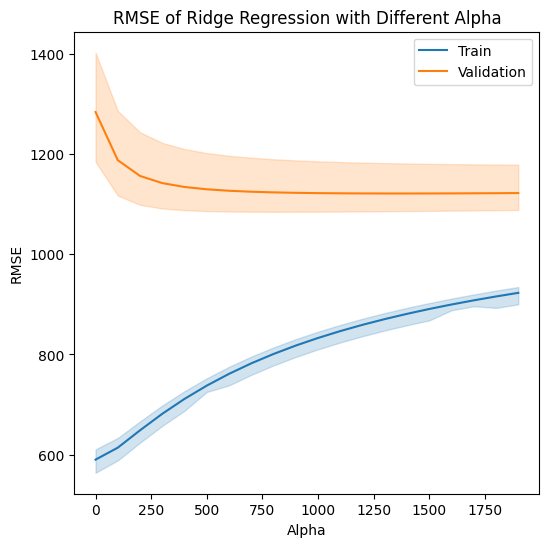

Best Alpha: 800.1 with Validation RMSE: 1084.9577483621993


In [83]:
alpha_range = np.arange(0.1, 2000, 100) #you can change the range or make it more granular
tuned_alpha, rmse_tuned_ridge = alpha_tuning(X_with_one_hot, y, alpha_range, cv=3, model_type='Ridge')

/Users/joeliang/miniforge3/envs/native/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e+10, tolerance: 6.025e+07
  model = cd_fast.enet_coordinate_descent(


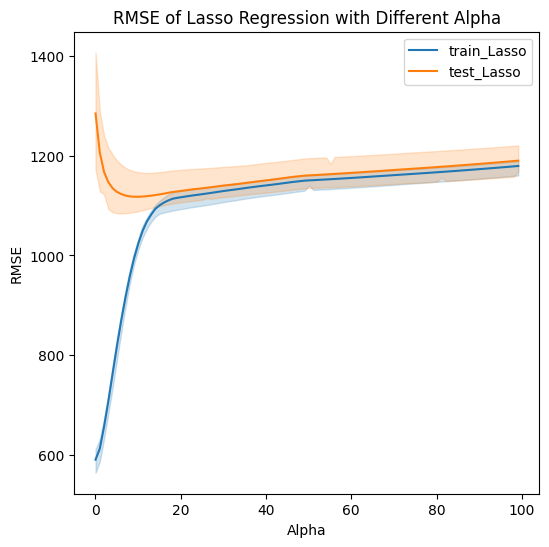

Best Alpha: 6.1 with Validation RMSE: 1084.4170359079696


In [ ]:
alpha_range = np.arange(0.1, 100, 1)
tuned_alpha, rmse_tuned_lasso = alpha_tuning(X_with_one_hot, y, alpha_range, cv=3, model_type='Lasso')

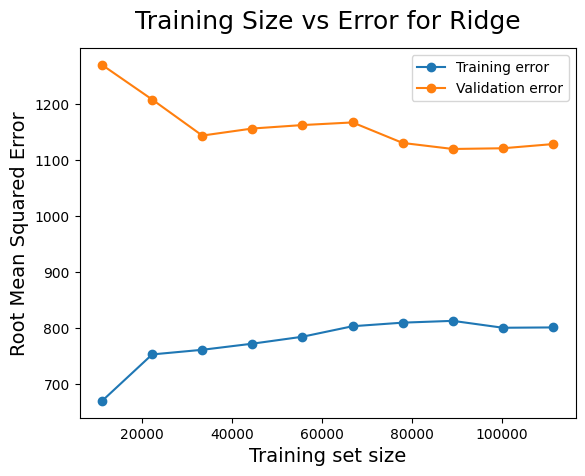

In [91]:
model_ridge = linear_model.Ridge(alpha=800)
plot_learning_curve_size(X_with_one_hot, y, model_ridge, cv = 5)
plt.show()

In this plot, you can see that validation error is decreasing toward the center of the plot, which is a good sign of our trained model.

Here we directly use the validation loss for hyperparameter tuning to eveluate our system, a better practice is using nest cross validation, where two loops of cross-validation are nested:

- Outer loop (for model evaluation): This loop is used to evaluate the generalization performance of the model. 
- Inner loop (for model tuning): Within each training fold of the outer loop, an inner cross-validation loop is run to perform hyperparameter tuning. 

More information: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

### Original Features + Features From Features Engineering
Next, we’ll add the new features that we derived from the original dataset features. We also need to convert DayofYear into one hot encoding

In [93]:
#adding feature
def add_columns(features, X_old, X):
    X_new = X_old.copy()
    for f in features:
         X_new[f] = X[f]
    return X_new

In [94]:
feature_eng = ['DayOfYear', 'WeeklyRollingMean', 'MonthlyRollingMean', 'DaysSinceLastPromo']
X_eng = add_columns(feature_eng, X_with_one_hot, X)
# convert DayOfYear to one hot encoding
X_eng = pd.get_dummies(X_eng, columns=['DayOfYear'], dtype=int)

In [95]:
model = linear_model.Ridge(alpha=0.5)
rmse_eng = cross_val(model, X_eng, y, cv=5)

Split 1: 1263.2492021993808
Split 2: 1188.6670589793416
Split 3: 1168.0686087786967
Split 4: 1325.5550017204378
Split 5: 1046.3328634395898
Mean RMSE with 95% CI: 1198.3745470234892 +/- 47.1767674312073


Tuning the `alpha` for the Ridge model using this set of feature. You should do it every time you train a different model, change a parameters, or use different features.

Alpha: 0.1
Alpha: 50.1
Alpha: 100.1
Alpha: 150.1
Alpha: 200.1
Alpha: 250.1
Alpha: 300.1
Alpha: 350.1
Alpha: 400.1
Alpha: 450.1
Best Alpha: 150.1 with Validation RMSE: 1011.1331855063034


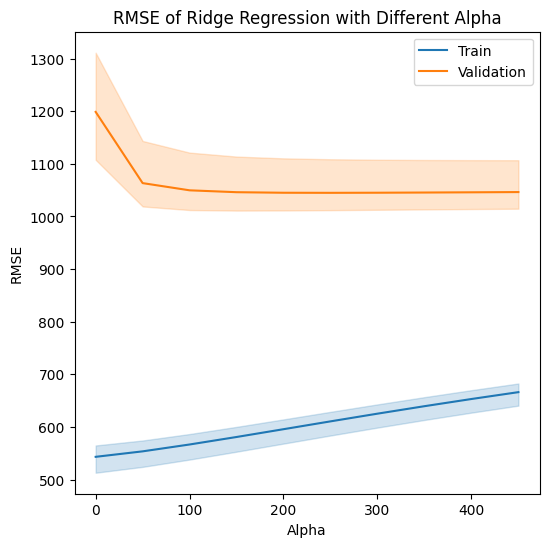

In [133]:
alpha_range = np.arange(0.1, 500, 50)
_, rmse_eng = alpha_tuning(X_eng, y, alpha_range, cv=3, model_type='Ridge')

### Original Features + Features From Features Engineering + Features From External
Lets use all features, including the one we created or merged from external dataset

In [98]:
X_train.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Promo', 'CompetitionDistance',
       'Year', 'Month', 'DayOfMonth', 'Public', 'Easter', 'Christmas',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'DayOfYear',
       'WeeklyRollingMean', 'MonthlyRollingMean', 'DaysSinceLastPromo',
       'Mean_TemperatureC', 'Mean_Wind_SpeedKm_h', 'Precipitationmm'],
      dtype='object')

In [100]:
# adding feature
feature_external = ['Mean_TemperatureC', 'Mean_Wind_SpeedKm_h', 'Precipitationmm']
X_external = add_columns(feature_external, X_eng, X)

# Cross Validation
model = linear_model.Ridge(alpha=0.5)
rmse_external = cross_val(model, X_external, y, cv=5)

Split 1: 1267.2799610682596
Split 2: 1190.0875661546038
Split 3: 1168.102238082778
Split 4: 1325.8967352634556
Split 5: 1048.6981808765204
Mean RMSE with 95% CI: 1200.0129362891234 +/- 47.10867452218675


Alpha: 0.1
Alpha: 50.1
Alpha: 100.1
Alpha: 150.1
Alpha: 200.1
Alpha: 250.1
Alpha: 300.1
Alpha: 350.1
Alpha: 400.1
Alpha: 450.1
Best Alpha: 150.1 with Validation RMSE: 1011.0504837321997


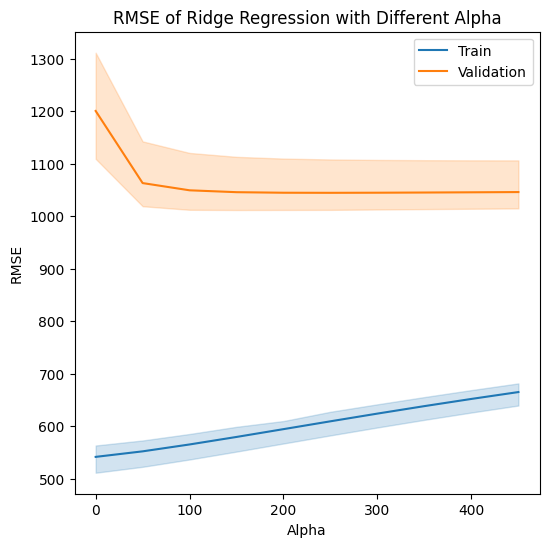

In [130]:
alpha_range = np.arange(0.1, 500, 50)
_, rmse_external  = alpha_tuning(X_external, y, alpha_range, cv=3, model_type='Ridge')

### Feature Selection with MI

We can select the top k features using the the mutual information bweteen features and sales we calculated before

for example, we can select the top 10 features

In [ ]:
# calculate the mutual information for all one hot encoded features
mi_all_with_one_hot = X_external.apply(lambda x: mutual_info_score(x, y), axis=0)
mi_all_with_one_hot  = mi_all_with_one_hot .sort_values(ascending=False)

In [102]:
mi_all_with_one_hot.head(10)

MonthlyRollingMean     7.175809
WeeklyRollingMean      5.925197
Customers              4.150762
CompetitionDistance    2.500057
Mean_TemperatureC      0.986112
Mean_Wind_SpeedKm_h    0.620807
DaysSinceLastPromo     0.428538
Precipitationmm        0.376148
Promo                  0.170891
Year                   0.106778
dtype: float64

In [103]:
top_features = mi_all_with_one_hot.index[:10]
top_features

Index(['MonthlyRollingMean', 'WeeklyRollingMean', 'Customers',
       'CompetitionDistance', 'Mean_TemperatureC', 'Mean_Wind_SpeedKm_h',
       'DaysSinceLastPromo', 'Precipitationmm', 'Promo', 'Year'],
      dtype='object')

In [104]:
#cross validation using top features
model_top = linear_model.Ridge(alpha=0.5)
rmse_top = cross_val(model_top, X_external[top_features], y, cv=5)

Split 1: 1144.0821813828452
Split 2: 1359.0800622934335
Split 3: 1243.200346015655
Split 4: 1228.8739607926043
Split 5: 1238.8381850248225
Mean RMSE with 95% CI: 1242.8149471018721 +/- 34.26080143929114


### Coordinate Descent
Same as `alpha`, the value of k is a hyperparameter to tune based on the validation error of model with top k features, we can visualize different value of K vs the RMSE of the model using cross validation

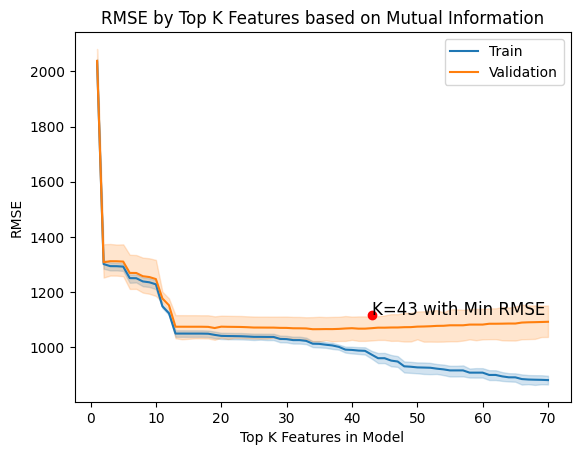

In [112]:
def feature_selection_mi (X, y, mi, top_k):
    #this function will return the rmse using the top k features with 5-fold cross validation
    top_features = mi.index[1:top_k+1]
    model = linear_model.Ridge(alpha=0.5)
    results = cross_validate(model, X[top_features], y, cv=5, 
                             scoring='neg_root_mean_squared_error', return_train_score=True)
    return results['test_score'], results['train_score']

def plot_k_by_rmse(X, y, mi, min_k, max_k):
    rmse = pd.DataFrame()
    # loop through the top k features in our selected range
    for i in range(min_k, max_k+1):
        # obtain the RMSE for the top k features
        test_rmse, train_rmse = feature_selection_mi(X, y, mi, i)  
        # store the result
        current_rmse = pd.DataFrame([test_rmse, train_rmse]).T
        current_rmse.columns = ['test', 'train']
        current_rmse = -current_rmse #convert to positive RMSE
        current_rmse['k'] = i #store the k value
        rmse = pd.concat([rmse, current_rmse])

    # plot the result
    sns.lineplot(x='k', y='train', data=rmse, errorbar='ci', label='Train')
    sns.lineplot(x='k', y='test', data=rmse,errorbar='ci', label='Validation')
    
    #highlight the minimum RMSE
    min_rmse = rmse['test'].min()
    min_k = rmse[rmse['test'] == min_rmse]['k'].values[0]
    plt.text(min_k, np.mean(rmse['test']), f'K={min_k} with Min RMSE', fontsize=12)
    plt.scatter(min_k,  np.mean(rmse['test']), color='red')
    plt.title(f'RMSE by Top K Features based on Mutual Information')
    plt.xlabel('Top K Features in Model')
    plt.ylabel('RMSE')

plot_k_by_rmse(X_external, y, mi_all_with_one_hot, 1, 70)

K = 43 has the lowest validation error by the 3-fold cross validation

Using this optimal value of `K`, let's tune the `alpha`

Best Alpha: 300.1 with Validation RMSE: 1025.1324720211624


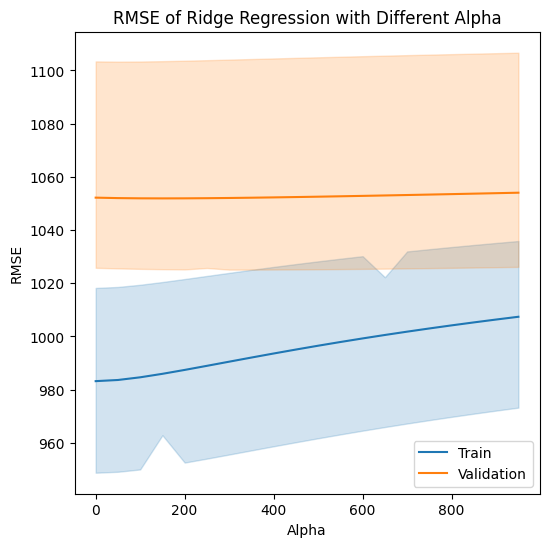

In [124]:
top_features = mi_all_with_one_hot.index[:43]
alpha_range = np.arange(0.1, 1000, 50)
tuned_alpha, rmse_top = alpha_tuning(X_external[top_features], y, alpha_range, cv=3, 
                                     model_type='Ridge')



**Note:** We have two hyperparameters to tune here—`K` and `alpha`. Adjusting the values of both will affect the RMSE.

By tuning them seperatly, this method is called Coordinate Descent. Rather than tuning them separately, a better approach is to tune both simultaneously. We can use Grid Search, which explores all possible combinations of the hyperparameters within a specified range (though this can be time-consuming), or Random Search, which tests a few possible combinations from a larger range to help narrow down the optimal values. Afterward, combining Random Search with Grid Search can strike a balance between performance and efficiency. 

We’ll discuss this further in a later section when we introduce models with more complex settings and hyperparameters.


### Testing Set

Let's see the performance of model with different set of features in the validation set

In [173]:
# Original Features without regularization or One Hot Encoding
baseline = linear_model.LinearRegression()
baseline.fit(X, y)
rmse_base = cross_val(baseline, X, y, cv=5)

Split 1: 1090.8424797374207
Split 2: 1132.6565724373397
Split 3: 1092.53157648979
Split 4: 1147.7641631528816
Split 5: 1156.8349263273608
Mean RMSE with 95% CI: 1124.1259436289588 +/- 13.797477310790926


In [174]:
result = pd.DataFrame({'Original Features (Excluding Store, Day of Month, and Day of Week) (No regularization)': [rmse_original],
              'Features Engineering (One Hot Encoded)': [rmse_eng],
              'Original Features + Store, Day of Month, and  Day of Week (One Hot Encoding)': [rmse_tuned_ridge],
              'All Features (Including External) (One Hot Encoding)': [rmse_external],
              'Top 43 Features From MI (One Hot Encoded)': [rmse_top],
              'Baseline: Original Features (No regularization or One Hot Encoding)': [rmse_base]},
             index=['RMSE from 10-fold CV']).T
np.round(result, 4).sort_values('RMSE from 10-fold CV')

,RMSE from 10-fold CV
All Features (Including External) (One Hot Encoding),1011.0505
Features Engineering (One Hot Encoded),1011.1332
Top 43 Features From MI (One Hot Encoded),1025.1325
"Original Features + Store, Day of Month, and Day of Week (One Hot Encoding)",1084.9577
Baseline: Original Features (No regularization or One Hot Encoding),1124.1259
"Original Features (Excluding Store, Day of Month, and Day of Week) (No regularization)",1165.4993


Linear regression using all available features showed the best performance on both the validation dataset and during cross-validation. Now, let's evaluate the performance of our model using the testing dataset, which contains entirely new data that the model has never seen before. This will give us a true indication of how well the model generalizes to unseen data.

In [192]:
test_data = pd.read_csv(DATA_DIR +'/test_lab.csv')
test_data.head()

,Store,Date,DayOfWeek,Customers,Promo,StateHoliday,Sales
0,1,2015-07-31,5,555,1,0,5263
1,2,2015-07-31,5,625,1,0,6064
2,3,2015-07-31,5,821,1,0,8314
3,4,2015-07-31,5,1498,1,0,13995
4,5,2015-07-31,5,559,1,0,4822


In [193]:
test_data.shape

(10277, 7)

In [194]:
test_data['Date'].min(), test_data['Date'].max(), len(test_data['Date'].unique())

('2015-06-02', '2015-07-31', 60)

We need to preprocess the data by creating new features in the test dataset to match the feature set of the training dataset. This ensures that both datasets have the same structure, which is crucial for the model to make accurate predictions.

In [195]:
# get the store data
test_data = pd.merge(test_data, store_data, on='Store')
test_data['CompetitionDistance'] =  test_data['CompetitionDistance'].fillna(data['CompetitionDistance'].max())

# convert the date to year, month, and day of the month
test_data['Year'] = test_data['Date'].apply(lambda x: int(x.split('-')[0]))
test_data['Month'] = test_data['Date'].apply(lambda x: int(x.split('-')[1]))
test_data['DayOfMonth'] = test_data['Date'].apply(lambda x: int(x.split('-')[2]))

#split StateHoliday into 4 variables
test_data = pd.concat([test_data, pd.get_dummies(test_data['StateHoliday'],
                                                 prefix='StateHoliday',dtype=int)], axis=1)
test_data.drop('StateHoliday', axis=1, inplace=True)
test_data.drop('StateHoliday_0', axis=1, inplace=True)
test_data.columns = test_data.columns.str.replace('StateHoliday_a', 'Public')
test_data.columns = test_data.columns.str.replace('StateHoliday_b', 'Easter')
test_data.columns = test_data.columns.str.replace('StateHoliday_c', 'Christmas')

# split Assortment into 4 variables
test_data = pd.concat([test_data, pd.get_dummies(test_data['StoreType'],
                                                 prefix='StoreType',dtype=int)], axis=1)
test_data.drop('StoreType', axis=1, inplace=True)

test_data = add_features(test_data)
test_data = add_external_data(test_data, store_to_states, weather_data,
                            ['Mean_TemperatureC', 'Mean_Wind_SpeedKm_h', 'Precipitationmm'])

test_data.drop('Date', axis=1, inplace=True)

We also need to perform One-Hot Encoding to match with training dataset

In [196]:
# One hot encoding for Store, DayOfWeek, and Month
test_data_with_one_hot = test_data.copy()
test_data_with_one_hot  = pd.get_dummies(test_data_with_one_hot, columns=['Store', 'DayOfWeek', 'Month'], dtype=int)
test_data_with_one_hot.rename(columns=mapper_week, inplace=True)
test_data_with_one_hot.rename(columns=mapper_month, inplace=True)
test_data_with_one_hot.drop(['Monday', 'Store_1'], axis=1, inplace=True)

In [197]:
test_data_with_one_hot.columns

Index(['Customers', 'Promo', 'Sales', 'CompetitionDistance', 'Year',
       'DayOfMonth', 'Public', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       ...
       'Store_622', 'Store_879', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'June', 'July'],
      dtype='object', length=226)

Note that there are columns is missing from the test dataset. This is because there are no sample has this value in the test data, which will not be converted into binary varible during one-hot encoding

To ensure consistency between the training and test datasets, we need to align the features in both datasets.

In [ ]:
for col in X_external.columns:
    if col not in test_data_with_one_hot.columns:
        test_data_with_one_hot[col] = 0

In [199]:
# make sure the columns are in the same order as the training data
X_test = test_data_with_one_hot[X_external.columns]
# predicting the sales using the test set
y_test = test_data_with_one_hot['Sales']
model_top = linear_model.Ridge(alpha=150.1) # our tuned hyperparameter
model_top.fit(X_external, y) # all features including external
y_pred = model_top.predict(X_test) # predict the sales

mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)
mse = mean_squared_error(y_true= y_test, y_pred = y_pred)
rmse = root_mean_squared_error(y_true= y_test, y_pred = y_pred)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 471.24413055525986
MSE: 472072.15018917015
RMSE: 687.0750688164795



## Gradient Boosting Regression (XGBoost)

In the previous section, we used linear regression to predict sales. Linear regression provides a straightforward way to understand the contribution of each feature to the model's predictions, making it a good starting point. However, in real-world scenarios, the relationship between store sales and the observed features may not be linear. To capture more complex patterns in the data, we often need more complex models. Gradient Boosting Regression is a powerful technique that can improve prediction accuracy by building an ensemble of decision trees in a sequential manner, where each tree corrects the errors of the previous one.

More information: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In [209]:
# hyperparameters
params = {
    "n_estimators": 500, #The number of boosting stages to perform
    "max_depth": 4, #The maximum depth limits the number of nodes in the tree
    "min_samples_split": 5, # minimum number of samples required to split an internal node
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# training time
time_start = time.time()
# create the model using the hyperparameters we defined
gb_model = GradientBoostingRegressor(**params)
gb_model.fit(X_train, y_train)
time_end = time.time()
print("Training time: ", time_end-time_start)

Training time:  95.67477703094482


In [210]:
y_pred = gb_model.predict(X_val)

In [211]:
mae_gb, mse_gb, rmse_gb = eveluate_model(y_val, y_pred)

Mean Absolute Error: 620.9134207938964
Mean Squared Error: 709838.5375812842
Root Mean Squared Error: 842.519161551406


In [ ]:
params = {
    "n_estimators": 500, #The number of boosting stages to perform
    "max_depth": 4, #The maximum depth limits the number of nodes in the tree
    "min_samples_split": 5, # minimum number of samples required to split an internal node
    "learning_rate": 0.01,
    "loss": "squared_error",
}
gb_model = GradientBoostingRegressor(**params)
rmse_gb = cross_val(gb_model, X, y, cv=5)

Split 1: 880.1507976787742
Split 2: 1108.8720888717994
Split 3: 964.9927978841397
Split 4: 1065.5780292391175
Split 5: 957.1521499186047
Mean RMSE with 95% CI: 995.3491727184871 +/- 40.9088819425536


### XG-Boost

One challenge with Gradient Boosting Trees in `sklearn` is the longer training time, which can become even more time-consuming when tuning hyperparameters (as multiple trials are needed). The `xgboost` package offers a more efficient implementation of Gradient Boosting, with a similar interface to Scikit-learn. `XGBoost` is optimized for speed and performance, making it a great alternative when working with large datasets or when frequent hyperparameter tuning is required.

https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

Let's try a different value for hyperparameter (learning_rate from 0.01 to 0.05)

In [162]:
params = {
    "n_estimators": 500, #The number of boosting stages to perform
    "max_depth": 4, #The maximum depth limits the number of nodes in the tree
    # xgboost do not have min_samples_split, you can try min_child_weight
    "learning_rate": 0.05,
    "objective":'reg:squarederror'
}
time_start = time.time()
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train)
time_end = time.time()
print("Training time: ", time_end-time_start)

Training time:  1.0152578353881836


We can see a much faster training time than Grident Boosting Regression in sklearn

#### Learning Curve with Epoches

The most commonly used learning curve plot illustrates the training versus validation error across various numbers of epochs, where an epoch refers to a complete pass through the training dataset when using grident descent to estimate the model weight (or coefficents in this case)

The below plot shows an example of overfiting. When the model is overfitting, you should observe a divergence between the training and validation errors. The training error decreases while the validation error starts to increase, indicating that the model is capturing noise in the training data rather than generalizing well to unseen data.

In this context, the loss function used in linear regression is typically the Mean Squared Error (MSE) or Root Mean Squared Error (RMSE).

![Learning Curve](https://www.baeldung.com/wp-content/uploads/sites/4/2022/02/img_6210aec599a86.svg)

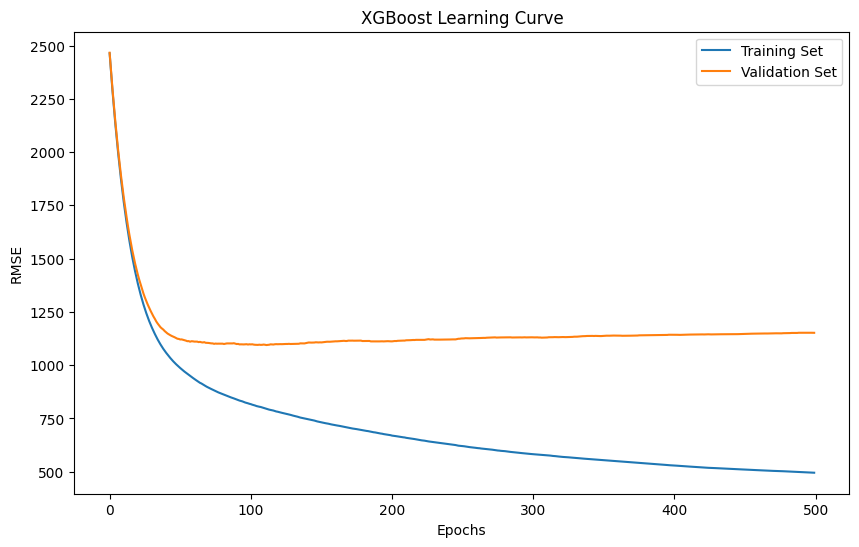

In [ ]:
# learning curve for xgboost
def xgb_learning_curve(model, X, y, cv=5):
    kf = KFold(n_splits=cv)
    train_curve = []
    val_curve = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
        results = model.evals_result()
        train_curve.append(results['validation_0']['rmse'])
        val_curve.append(results['validation_1']['rmse'])

    plt.figure(figsize=(10, 6))
    mean_train = np.mean(train_curve, axis=0)
    mean_val = np.mean(val_curve, axis=0)
    plt.plot(mean_train, label='Training Set')
    plt.plot(mean_val, label='Validation Set')
    plt.title("XGBoost Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()


xgb_model = xgb.XGBRegressor(**params)
xgb_learning_curve(xgb_model, X, y, cv=5)

What does this plot tell you?

The reason we don’t typically see overfitting behavior in XGBoost is that XGBoost is designed to avoid overfitting. This characteristic makes it highly effective in competitions and real-world scenarios. 

However, the learning curves you observe in XGBoost, where the validation error consistently decreases, are unique to this type of model. For most other regressors, especially simpler models like linear regression or even neural networks, you would generally see a point where the validation error starts increasing after a certain number of epochs, indicating overfitting. 

This distinction highlights the robustness of XGBoost in managing model complexity while maintaining generalization.

Let's eveluate the performance with cross validation

In [161]:
params = {
    "n_estimators": 500, #The number of boosting stages to perform
    "max_depth": 4, #The maximum depth limits the number of nodes in the tree
    # xgboost do not have min_samples_split, you can try min_child_weight
    "learning_rate": 0.05,
    "objective":'reg:squarederror'
}
xgb_model = xgb.XGBRegressor(**params)
rmse_xgb = cross_val(xgb_model, X, y, cv=5)

Split 1: 1374.9971700305393
Split 2: 1097.5848808629005
Split 3: 1009.6603339805256
Split 4: 1099.8624931064535
Split 5: 1176.7358132180373
Mean RMSE with 95% CI: 1151.768138239691 +/- 61.75728088093026


Note that the performance of model in validation error (Compared to Grident Boosting in sklearn) decline since we changed the hyperparameter `learning_rate` from 0.01 to 0.05.

### XG-Boost with All features After One-hot Encoding

XG-Boost with all features, after one-hot encoding

In [159]:
xgb_model = xgb.XGBRegressor(**params)
rmse_xgb = cross_val(xgb_model, X_external, y, cv=5)

Split 1: 973.2891375055314
Split 2: 1107.1427888746396
Split 3: 1038.1507441462097
Split 4: 1099.2378684867363
Split 5: 1044.4650772016769
Mean RMSE with 95% CI: 1052.4571232429587 +/- 24.202350505323427


We can also check the feature importance in `xgboost`, the weight means the number of times a feature appears in a tree

https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.plotting

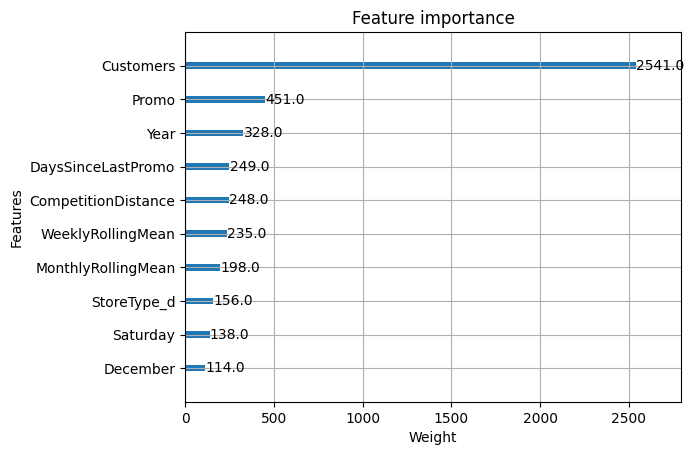

In [164]:
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_external, y)
axes = xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
axes.set_xlabel('Weight')
plt.show()

### Hyperparameter Tuning in XGb

Different hyperparameters can significantly impact the performance of a model. By carefully tuning these hyperparameters, we can optimize the model’s performance and find the best configuration that generalizes well to unseen data.

Let’s look at an example of Root Mean Squared Error (RMSE) on the validation dataset using Gradient Boosting with four different learning rates.

In [165]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

In [177]:
for lr in learning_rates:
    params = {
        "n_estimators": 500, #The number of boosting stages to perform
        "max_depth": 4, #The maximum depth limits the number of nodes in the tree
        # xgboost do not have min_samples_split, you can try min_child_weight
        "learning_rate": lr,
        "objective":'reg:squarederror'
    }
    model = xgb.XGBRegressor(**params)
    mean_rsme = cross_val(model, X_external, y, cv=5, verbose=False)
    print(f"Learning Rate: {lr}, RMSE: {mean_rsme}")

Learning Rate: 0.001, RMSE: 1851.0821033846755
Learning Rate: 0.01, RMSE: 1097.10306350066
Learning Rate: 0.05, RMSE: 1151.768138239691
Learning Rate: 0.1, RMSE: 1170.35951147444
Learning Rate: 0.5, RMSE: 1307.407783561125
Learning Rate: 1, RMSE: 1395.7001612362706


Recall in linear regression, we metioned about searching all combination using Grid and Random Search. Instead of manually searching for the best hyperparameters, Scikit-learn provides tools to automate this process:

- **GridSearchCV**: This method exhaustively searches through a specified range of hyperparameters to find the optimal combination for the model. It evaluates every possible combination of hyperparameter values.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

  
- **RandomizedSearchCV**: Unlike GridSearchCV, this method randomly samples a specified number of combinations from the hyperparameter space, which can be more efficient for large datasets or extensive hyperparameter ranges.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Both tools help streamline hyperparameter tuning, allowing you to efficiently find the best configuration without manual trial and error.


In [212]:
params = {
    "n_estimators": [200, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.01, 0.05, 0.1],
}

model = xgb.XGBRegressor()

grid_search = GridSearchCV(model, param_grid=params, cv=5,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(X_external, y)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6], 'n_estimators': [200, 500]},
             scoring='neg_root_mean_squared_error')

In [213]:
cv_result = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,6.327409,0.195174,0.134249,0.005187,0.10,6,500,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",-956.904561,-1107.357763,-1045.395610,-1075.603533,-1010.150311,-1039.082356,52.202371,1
6,3.602420,0.088191,0.107429,0.006528,0.05,6,200,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",-941.417183,-1117.335366,-1043.331591,-1088.513539,-1011.048631,-1040.329262,61.484361,2
7,6.795127,0.129743,0.128269,0.008265,0.05,6,500,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",-949.000192,-1120.031430,-1031.700184,-1082.334079,-1019.371459,-1040.487469,58.260458,3
9,5.854215,0.159485,0.111069,0.005226,0.10,4,500,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-955.929102,-1120.208813,-1008.943510,-1088.236982,-1031.697174,-1041.003116,58.063047,4
3,9.385609,0.139264,0.132639,0.009748,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-944.535203,-1122.043097,-1054.731518,-1089.403402,-1008.784648,-1043.899573,62.290731,5


We can select the top 5 hyperparameters based on the mean RMSE in the Grid Search CV

In [214]:
cv_result[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'mean_test_score']].head()

,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score
11,500,6,0.10,-1039.082356
6,200,6,0.05,-1040.329262
7,500,6,0.05,-1040.487469
9,500,4,0.10,-1041.003116
3,500,6,0.01,-1043.899573


Obtaining the hyperparameter with the lowest mean RMSE

In [215]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

And retreived the best model for prediction

In [216]:
best_model = grid_search.best_estimator_

In [228]:
result = pd.DataFrame({'Original Features (Excluding Store, Day of Month, and Day of Week) (No regularization)': [rmse_original],
              'Features Engineering (One Hot Encoded)': [rmse_eng],
              'Original Features + Store, Day of Month, and  Day of Week (One Hot Encoding)': [rmse_tuned_ridge],
              'All Features (Including External) (One Hot Encoding)': [rmse_external],
              'Top 43 Features From MI (One Hot Encoded)': [rmse_top],
              'Baseline: Original Features (No regularization or One Hot Encoding)': [rmse_base],
              'XGBoost with All Features (Including External) (One Hot Encoding) ': [1039.082356]},
             index=['RMSE from 10-fold CV']).T
np.round(result, 4).sort_values('RMSE from 10-fold CV')

,RMSE from 10-fold CV
All Features (Including External) (One Hot Encoding),1011.0505
Features Engineering (One Hot Encoded),1011.1332
Top 43 Features From MI (One Hot Encoded),1025.1325
XGBoost with All Features (Including External) (One Hot Encoding),1039.0824
"Original Features + Store, Day of Month, and Day of Week (One Hot Encoding)",1084.9577
Baseline: Original Features (No regularization or One Hot Encoding),1124.1259
"Original Features (Excluding Store, Day of Month, and Day of Week) (No regularization)",1165.4993


Let's use this tuned model to predict the sale for the same test dataset

In [225]:
y_pred = best_model.predict(test_data_with_one_hot[X_external.columns])

eveluate_model(y_test, y_pred)

Mean Absolute Error: 383.86715279245374
Mean Squared Error: 265959.178580452
Root Mean Squared Error: 515.712302141855


(383.86715279245374, 265959.178580452, 515.712302141855)